<a href="https://colab.research.google.com/github/bostaals/networkanalysis/blob/main/Predicting_negative_and_positive_ties.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Predicting Positive and Negative Ties in Signed Networks

#### A Comparative Study on Wikipedia Adminship and School Friendship Networks

Bo Staals <br>
06 07 2023

## 1. Libraries

In [ ]:
!pip install distinctipy

import pandas as pd
import numpy as np
import networkx as nx
import random
import matplotlib.pyplot as plt
from sklearn.inspection import permutation_importance
import itertools
from sklearn.linear_model import LogisticRegression
import lightgbm as lgb
from sklearn.metrics import make_scorer, precision_recall_curve, roc_auc_score, confusion_matrix, accuracy_score, precision_score, recall_score, multilabel_confusion_matrix, classification_report, f1_score, adjusted_rand_score, roc_curve, auc
from sklearn.preprocessing import label_binarize
from itertools import cycle
from sklearn._loss.loss import xlogy
from sklearn.feature_selection import RFECV
from sklearn.model_selection import cross_validate, GroupKFold, KFold, StratifiedKFold, cross_val_predict, GridSearchCV, train_test_split
import distinctipy
import seaborn as sns

# 2. Pre-processing

In [ ]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


### 2.1 Loading the datasets

The wikipedia dataset is open source and extracted from: https://snap.stanford.edu/data/wiki-RfA.html

The school dataset is not open source. You can apply for obtaining the dataset from: https://www.cils4.eu/index.php?option=com_content&view=article&id=5&Itemid=6

**Wikipedia dataset**

In [ ]:
# Read the dataset from the text file

def read_df(input_file):

  """Read the txt file as a pandas dataframe.

  Args:
    input_file = txt input file

  Returns:
    pd.DataFrame = dataframe from txt file
  """

  with open(input_file, "r") as file:
      dataset_text = file.read()

  # Split the dataset text into individual records
  records = dataset_text.strip().split("\n\n")

  # Initialize empty lists for each column
  src_list = []
  tgt_list = []
  vot_list = []
  res_list = []
  yea_list = []
  dat_list = []
  txt_list = []

  # Extract values for each column from the records
  for record in records:
      lines = record.strip().split("\n")
      record_dict = {}
      for line in lines:
          key, value = line.split(":", 1)
          record_dict[key.strip()] = value.strip()
      src_list.append(record_dict.get("SRC"))
      tgt_list.append(record_dict.get("TGT"))
      vot_list.append(record_dict.get("VOT"))
      res_list.append(record_dict.get("RES"))
      yea_list.append(record_dict.get("YEA"))
      dat_list.append(record_dict.get("DAT"))
      txt_list.append(record_dict.get("TXT"))

  # Create a dataframe from the lists
  wikipedia = pd.DataFrame({
      "SOURCE": src_list,
      "TARGET": tgt_list,
      "VOTE": vot_list,
      "RES": res_list,
      "YEA": yea_list,
      "DAT": dat_list,
      "TXT": txt_list
  })

  return wikipedia

In [ ]:
# Load the dataframe
wiki_full_df = read_df("/content/drive/MyDrive/wiki-RfA.txt")
wiki_df = wiki_full_df[["SOURCE","TARGET", "VOTE", "DAT"]]

# Exclude neutral edges
wiki_df["VOTE"] = wiki_df["VOTE"].astype(int)
wiki_df = wiki_df[wiki_df["VOTE"] != 0]

<ipython-input-8-910840ca9b53>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  wiki_df["VOTE"] = wiki_df["VOTE"].astype(int)


**School dataset**

We want to keep the following columns:

- `youthid` : Unique Youth ID
- `classid` : Unique Class ID
- `schoolid` : Unique School ID
- `schtype_nl` : School type (Netherlands)
- `y1_bfs_{1,2,3,4,5}` : Best Friends, nomination 1 - 5
- `y1_sit_{1,2,3,4,5}` : Not want to sit by, nomination 1 - 5
- `y1_pos_{1,2,3,4,5}` : Popular Students in class, nomination 1 - 5
- `y1_tos_{1 - 32}` : Often spend time with outside school, nomination 1 - 32
- `y1_mean1_{1 - 32}` : Sometimes mean to you, nomination 1 - 32
- `y1_hw_{1 - 32}` : Sometimes do homework with, nomination 1 - 32
- `y1_mean2_{1 - 32}` : Sometimes mean to, nomination 1 - 32

In [ ]:
# Load dataframe
school_df = pd.read_stata("/content/drive/MyDrive/w1_yc_nl_v1.3.0_rv.dta")

# Only keep the important columns
school_df = school_df[["youthid", "classid", "schoolid", "schtype_nl",
         "y1_bfs_1", "y1_bfs_2", "y1_bfs_3", "y1_bfs_4", "y1_bfs_5",
         "y1_sit_1", "y1_sit_2", "y1_sit_3", "y1_sit_4", "y1_sit_5",
         "y1_pos_1", "y1_pos_2", "y1_pos_3", "y1_pos_4", "y1_pos_5",
         "y1_tos_1", "y1_tos_2", "y1_tos_3", "y1_tos_4", "y1_tos_5", "y1_tos_6", "y1_tos_7", "y1_tos_8", "y1_tos_9", "y1_tos_10",
         "y1_tos_11", "y1_tos_12", "y1_tos_13", "y1_tos_14", "y1_tos_15", "y1_tos_16", "y1_tos_17", "y1_tos_18", "y1_tos_19", "y1_tos_20",
         "y1_tos_21", "y1_tos_22", "y1_tos_23", "y1_tos_24", "y1_tos_25", "y1_tos_26", "y1_tos_27", "y1_tos_28", "y1_tos_29", "y1_tos_30",
         "y1_tos_31", "y1_tos_32",
         "y1_mean1_1", "y1_mean1_2", "y1_mean1_3", "y1_mean1_4", "y1_mean1_5", "y1_mean1_6", "y1_mean1_7", "y1_mean1_8", "y1_mean1_9", "y1_mean1_10",
         "y1_mean1_11", "y1_mean1_12", "y1_mean1_13", "y1_mean1_14", "y1_mean1_15", "y1_mean1_16", "y1_mean1_17", "y1_mean1_18", "y1_mean1_19", "y1_mean1_20",
         "y1_mean1_21", "y1_mean1_22", "y1_mean1_23", "y1_mean1_24", "y1_mean1_25", "y1_mean1_26", "y1_mean1_27", "y1_mean1_28", "y1_mean1_29", "y1_mean1_30",
         "y1_mean1_31", "y1_mean1_32",
         "y1_hw_1", "y1_hw_2", "y1_hw_3", "y1_hw_4", "y1_hw_5", "y1_hw_6", "y1_hw_7", "y1_hw_8", "y1_hw_9", "y1_hw_10",
         "y1_hw_11", "y1_hw_12", "y1_hw_13", "y1_hw_14", "y1_hw_15", "y1_hw_16", "y1_hw_17", "y1_hw_18", "y1_hw_19", "y1_hw_20",
         "y1_hw_21", "y1_hw_22", "y1_hw_23", "y1_hw_24", "y1_hw_25", "y1_hw_26", "y1_hw_27", "y1_hw_28", "y1_hw_29", "y1_hw_30",
         "y1_hw_31", "y1_hw_32",
         "y1_mean2_1", "y1_mean2_2", "y1_mean2_3", "y1_mean2_4", "y1_mean2_5", "y1_mean2_6", "y1_mean2_7", "y1_mean2_8", "y1_mean2_9", "y1_mean2_10",
         "y1_mean2_11", "y1_mean2_12", "y1_mean2_13", "y1_mean2_14", "y1_mean2_15", "y1_mean2_16", "y1_mean2_17", "y1_mean2_18", "y1_mean2_19", "y1_mean2_20",
         "y1_mean2_21", "y1_mean2_22", "y1_mean2_23", "y1_mean2_24", "y1_mean2_25", "y1_mean2_26", "y1_mean2_27", "y1_mean2_28", "y1_mean2_29", "y1_mean2_30",
         "y1_mean2_31", "y1_mean2_32"]]

# Extract the youthid, classid and schoolid
school_df_order = school_df[["youthid", "classid", "schoolid"]]

# Extract the popular student columns
school_df_popular = school_df[["youthid", "y1_pos_1", "y1_pos_2", "y1_pos_3", "y1_pos_4", "y1_pos_5"]]

### 2.2 Check missing data

**Wikipedia dataset**

In [ ]:
# Print the amount of missing values
print("The total amount of missing values are: ", wiki_df.isna().sum().sum())
print("The amount of missing values in each column are: ")
wiki_df.isna().sum()

The total amount of missing values are:  0
The amount of missing values in each column are: 


SOURCE    0
TARGET    0
VOTE      0
DAT       0
dtype: int64

**School dataset**

The school dataset contains three kinds of missing values:
- Other missing : Answers that could not be coded, fun answers
- Not applicable : Not answered due to a filter question
- No answer : No answer given

In [ ]:
# Replace the missing values with 'NA'
school_df.replace(["no answer", "not applicable", "other missing"],
                  inplace = True,
                  value = np.nan)

# Print the amount of missing values
print("The total amount of missing values are: ", school_df.isna().sum().sum())
print("The amount of missing values in each column are: ")
school_df.isna().sum()

The total amount of missing values are:  558480
The amount of missing values in each column are: 


youthid           0
classid           0
schoolid          0
schtype_nl        0
y1_bfs_1        121
               ... 
y1_mean2_28    4286
y1_mean2_29    4286
y1_mean2_30    4286
y1_mean2_31    4286
y1_mean2_32    4286
Length: 147, dtype: int64

### 2.3 Transform and delete missing values in school dataset

The school dataset contains missing values. These missing values need to be deleted. Moreover, the school dataset needs to be transformed to an edge list dataframe, like the wikipedia dataset.

In [ ]:
def edge_df(df, school_df_order, positive_columns, negative_columns, reverse_variables):

  """
  Transform a node-wise pandas dataframe into an edge list pandas dataframe. It performs the following steps:
    1) Make an edge_list dataframe of every positive edge
    2) Make an edge_list dataframe of every negative edge
    3) Concatenate the two edge_list dataframes
    4) Remove missing values, which are represented as "-9223372036854775808"
    5) Add the classid and sourceid based on target and source node
    6) Swap the source and target columns from 'mean to you' variable

  Args:
    df = node-wise DataFrame
    school_df_order = DataFrame with extra variables that need to be merged
    positive_columns = columns assigned with a positive link
    negative_columns = columns assigned with a negative link
    reversed_variables = variables where the from and to node need to be switches

  Returns:
    pd.DataFrame = edge list dataframe
  """

  # Make the positive edges dataframe
  pos_edges = pd.melt(df,
                    id_vars = ["youthid"],
                    value_vars = positive_columns,
                    value_name = "TARGET").rename(columns = {"youthid": "SOURCE",
                                                             "variable": "VARIABLE"})
  pos_edges["VOTE"] = 1

  # Make the negative edges dataframe
  neg_edges = pd.melt(df,
                    id_vars = ["youthid"],
                    value_vars = negative_columns,
                    value_name = "TARGET").rename(columns = {"youthid": "SOURCE",
                                                             "variable": "VARIABLE"})
  neg_edges["VOTE"] = -1

  # Add two datasets together
  edge_df = pd.concat([pos_edges, neg_edges],
                      ignore_index = True)

  # Remove the missing values (-9223372036854775808)
  edge_df.replace(-9223372036854775808,
                  np.nan,
                  inplace=True)
  edge_df.dropna(inplace = True)
  edge_df["TARGET"] = edge_df["TARGET"].astype(int)

  # Add the classid and schoolid
  edge_df = pd.merge(edge_df, school_df_order[["youthid", "classid", "schoolid"]], left_on="SOURCE", right_on="youthid", how="left")
  edge_df.drop(columns="youthid", inplace=True)
  edge_df.rename(columns={"classid": "CLASSID_SOURCE", "schoolid": "SCHOOLID_SOURCE"}, inplace=True)
  edge_df = pd.merge(edge_df, school_df_order[["youthid", "classid", "schoolid"]], left_on="TARGET", right_on="youthid", how="left")
  edge_df.drop(columns="youthid", inplace=True)
  edge_df.rename(columns={"classid": "CLASSID_TARGET", "schoolid": "SCHOOLID_TARGET"}, inplace=True)

  # Reverse the SOURCE and TARGET column
  edge_df.loc[edge_df["VARIABLE"].isin(reverse_variables), ["SOURCE", "TARGET"]] = edge_df.loc[edge_df["VARIABLE"].isin(reverse_variables), ["TARGET", "SOURCE"]].values

  return edge_df

In [ ]:
# Define the positive columns
positive_columns = ["y1_bfs_1", "y1_bfs_2", "y1_bfs_3", "y1_bfs_4", "y1_bfs_5",
                    "y1_tos_1", "y1_tos_2", "y1_tos_3", "y1_tos_4", "y1_tos_5",
                    "y1_tos_6", "y1_tos_7", "y1_tos_8", "y1_tos_9", "y1_tos_10",
                    "y1_tos_11", "y1_tos_12", "y1_tos_13", "y1_tos_14", "y1_tos_15",
                    "y1_hw_1", "y1_hw_2", "y1_hw_3", "y1_hw_4", "y1_hw_5", "y1_hw_6",
                    "y1_hw_7", "y1_hw_8", "y1_hw_9", "y1_hw_10"]

# Define the negative columns
negative_columns = ["y1_sit_1", "y1_sit_2", "y1_sit_3", "y1_sit_4", "y1_sit_5",
                    "y1_mean1_1", "y1_mean1_2", "y1_mean1_3", "y1_mean1_4", "y1_mean1_5",
                    "y1_mean1_6", "y1_mean1_7", "y1_mean1_8", "y1_mean1_9", "y1_mean1_10",
                    "y1_mean1_11", "y1_mean1_12", "y1_mean1_13", "y1_mean1_14", "y1_mean1_15",
                    "y1_mean1_16", "y1_mean1_17", "y1_mean2_1", "y1_mean2_2", "y1_mean2_3",
                    "y1_mean2_4", "y1_mean2_5", "y1_mean2_6", "y1_mean2_7", "y1_mean2_8",
                    "y1_mean2_9", "y1_mean2_10", "y1_mean2_11", "y1_mean2_12", "y1_mean2_13",
                    "y1_mean2_14", "y1_mean2_15", "y1_mean2_16", "y1_mean2_17", "y1_mean2_18",
                    "y1_mean2_19", "y1_mean2_20", "y1_mean2_21", "y1_mean2_22", "y1_mean2_23", "y1_mean2_24"]

reverse_variables = ["y1_mean1_1", "y1_mean1_2", "y1_mean1_3", "y1_mean1_4", "y1_mean1_5",
                           "y1_mean1_6", "y1_mean1_7", "y1_mean1_8", "y1_mean1_9", "y1_mean1_10",
                           "y1_mean1_11", "y1_mean1_12", "y1_mean1_13", "y1_mean1_14", "y1_mean1_15",
                           "y1_mean1_16", "y1_mean1_17"]

school_df = edge_df(school_df, school_df_order, positive_columns, negative_columns, reverse_variables)

In [ ]:
# Print the amount of missing values
print("The total amount of missing values are: ", school_df.isna().sum().sum())
print("The amount of missing values in each column are: ")
school_df.isna().sum()

The total amount of missing values are:  7006
The amount of missing values in each column are: 


SOURCE                0
VARIABLE              0
TARGET                0
VOTE                  0
CLASSID_SOURCE        0
SCHOOLID_SOURCE       0
CLASSID_TARGET     3503
SCHOOLID_TARGET    3503
dtype: int64

The missing values in CLASSID and SCHOOLID are due to that these students have not been questioned.

### 2.4 Check the duplicates

Duplicated rows = total amount of duplicates in the dataset <br>
Contradictory duplicated rows = duplicates with a contradictory sign

In [ ]:
def duplicate_check(df, name):

  """
  Check the amount of edges in the dataframe, the amount of duplicates and the amount of contradictory duplicates.

  Args:
    df = edge list dataframe
    name = name of the dataframe

  Returns:
    prints wit the amount of edges, total duplicates and contradictory duplicates
  """

  # Check for duplicates in "SOURCE" and "TARGET" combination
  duplicates_ = df.duplicated(subset=["SOURCE", "TARGET"],
                              keep=False)

  # Group the data by "SOURCE" and "TARGET" and check if the votes differ within each group
  grouped = df.groupby(["SOURCE", "TARGET"])

  # Filter the groups where the votes differ within each group
  contradictory_groups = grouped.filter(lambda group: group["VOTE"].nunique() > 1)

  # Display the rows with contradictory vote numbers
  rows_with_contradictory_votes = contradictory_groups.sort_values(["SOURCE", "TARGET"])

  # Set up the print statements
  print("The total amount of edges in the", name, "dataset are: ", df.shape[0])
  print("The amount of total duplicated rows in the", name, "dataset are: ", df.duplicated(subset=["SOURCE", "TARGET"]).sum())
  print("The amount of contradictory duplicated rows in the", name, "dataset is: ", rows_with_contradictory_votes.shape[0])


**Wikipedia dataset**

In [ ]:
duplicate_check(wiki_df, "wikipedia")

The total amount of edges in the wikipedia dataset are:  185627
The amount of total duplicated rows in the wikipedia dataset are:  7531
The amount of contradictory duplicated rows in the wikipedia dataset is:  2882


**School dataset**

In [ ]:
duplicate_check(school_df, "school")

The total amount of edges in the school dataset are:  43765
The amount of total duplicated rows in the school dataset are:  13849
The amount of contradictory duplicated rows in the school dataset is:  3612


### 2.5 Delete the duplicates

In [ ]:
def delete_duplicates(df, order_column):

  """
  Delete the duplicates based on the order column.

  Args:
    df = edge list dataframe
    order_column = column to order on

  Returns:
    print statement with total amount of duplicated rows left
  """

  # Sort the wikipedia dataframe based on date
  df.sort_values(by = order_column,
                 ascending = False,
                 inplace = True)

  # Drop the duplicates
  df.drop_duplicates(subset = ["SOURCE", "TARGET"],
                     keep = "first",
                     inplace = True)

  # Print if there are any duplicates left
  print("The amount of total duplicated rows in the wikipedia dataset are: ", df.duplicated(subset=["SOURCE", "TARGET"]).sum())

**Wikipedia dataset**

There are 7531 duplicates found, among which 2881 with a contradictory sign. We have to keep the last vote, based on the datetime.

In [ ]:
# Transform DAT to a datetime variable
wiki_df["DAT"] = pd.to_datetime(wiki_df["DAT"],
                                format = "%H:%M, %d %B %Y",
                                errors = "coerce")


# Delete duplicates
delete_duplicates(wiki_df, "DAT")

The amount of total duplicated rows in the wikipedia dataset are:  0


**School dataset**

There are 13849 duplicates found among which 3612 duplicates with a contradictory sign. We want to keep the duplicates from the most promising variables. We have to keep only the duplicates from the most important variables `y1_bfs_{1,2,3,4,5} *Best Friends*` and `y1_sit_{1,2,3,4,5} *Not want to sit by*`.

In [ ]:
# Make a new variable based and give it a score 1 if it is the most important variable and 0 if not.
school_df["ORDER"] = np.where(
    (school_df["VARIABLE"] == "y1_bfs_1") | (school_df["VARIABLE"] == "y1_bfs_2") |
    (school_df["VARIABLE"] == "y1_bfs_3") | (school_df["VARIABLE"] == "y1_bfs_4") |
    (school_df["VARIABLE"] == "y1_bfs_5") | (school_df["VARIABLE"] == "y1_sit_1") |
    (school_df["VARIABLE"] == "y1_sit_2") | (school_df["VARIABLE"] == "y1_sit_3") |
    (school_df["VARIABLE"] == "y1_sit_4") | (school_df["VARIABLE"] == "y1_sit_5"),
    1,
    0)

# Delete duplicates
delete_duplicates(school_df, "ORDER")

The amount of total duplicated rows in the wikipedia dataset are:  0


### 2.6 Reciprocated links

In [ ]:
def reciprocated_links(df):

  """
  Check the amount of reciprocated links in the edge list.

  Args:
    df = edge list dataframe

  Return:
    total amount of reciprocated links

  """
  # Copy the df
  check = df.copy()

  # Store reciprocated links
  reciprocated = set()

  # See if reciprocated links exist
  check["reciprocated"] = check["TARGET"].astype(str) + "_" + check["SOURCE"].astype(str)
  reverse_exists = check["reciprocated"].isin(check["SOURCE"].astype(str) + "_" + check["TARGET"].astype(str))
  reverse_rows = df[reverse_exists]

  # Iterate over each row in the dataframe
  for i, row in reverse_rows.iterrows():
    source = row["SOURCE"]
    target = row["TARGET"]

    # Add every reciprocated link to the set
    reciprocated.add((source, target))

  return len(reciprocated)


**Wikipedia dataset**

In [ ]:
print("The total amount of reciprocated links in wikipedia dataset are: ", reciprocated_links(wiki_df))
print("This is ", (reciprocated_links(wiki_df) / len(wiki_df)) * 100 ," % of the total amount of edges")


The total amount of reciprocated links in wikipedia dataset are:  12988
This is  7.292696074027491  % of the total amount of edges


**School dataset**

In [ ]:
print("The total amount of reciprocated links in school dataset are: ", reciprocated_links(school_df))
print("This is ", (reciprocated_links(school_df) / len(school_df)) * 100 ," % of the total amount of edges")


The total amount of reciprocated links in school dataset are:  16480
This is  55.087578553282526  % of the total amount of edges


### 2.7 Delete all edges to other classes

In [ ]:
def same_class(df):

  """
  Counts the amount of time the classID of the source and target person is the same.
  This represents the amount of time that a student has voted for somebody within their class,
  or outside their class.

  Args:
    df = pandas dataframe

  Return:
    classid_counts = count of classes
  """

  # Make new column with confirmation if class id is the same for source and target
  df["SAME_CLASSID"] = ["yes" if source == target else "no" for source, target in zip(df["CLASSID_SOURCE"], df["CLASSID_TARGET"])]

  # Count the classes in this new column
  classid_counts = df["SAME_CLASSID"].value_counts()

  return print("\nSOURCE AND TARGET HAVE SAME CLASS ID:"), classid_counts


In [ ]:
def delete_same_class(df):

  """
  Delete the edges where the classID of the source and target person is the same.

  Args:
    df = pandas dataframe

  Return:
    df = pandas dataframe

  """
  filtered_df = df.copy()
  filtered_df = filtered_df[filtered_df["CLASSID_SOURCE"] == filtered_df["CLASSID_TARGET"]]

  return filtered_df

**School dataset**

In [ ]:
same_class(school_df)


SOURCE AND TARGET HAVE SAME CLASS ID:


(None,
 yes    27333
 no      2583
 Name: SAME_CLASSID, dtype: int64)

In [ ]:
school_df = delete_same_class(school_df)

### 2.8  Convert edge list to network

In [ ]:
def convert_to_network(df):

  """
  Converts edge list dataframe to a network

  Args:
    df = edge list pandas dataframe

  Returns:
    g = networkx graph
  """

  # Add the pandas dataframe to graph
  g = nx.from_pandas_edgelist(df,
                              source = "SOURCE", #Source nodes
                              target = "TARGET", #Target node
                              edge_attr = "VOTE",
                              create_using = nx.DiGraph)

  return g

**Wikipedia dataset**

In [ ]:
g_wiki = convert_to_network(wiki_df)

**School dataset**

In [ ]:
g_school = convert_to_network(school_df)

## 3. Exploratory Data Analysis

### 3.1 Statistics

In [ ]:
def count_triads(g):

  """
  Counts the amount of ppp, ppn, pnn and nnn triads in the dataset.
  Also considers reprocicated links and excludes them from the count.

  Args:
    g = networkx graph

  Returns:
    print statements for counts
  """

  # Variables to count the triads
  ppp = 0
  ppn = 0
  pnn = 0
  nnn = 0

  # Iterate over all nodes in the graph
  for node in g.nodes():

    # Find the successors of this node (outgoing edge)
    successors = g.successors(node)

    # Iterate over pairs of successors for the current node
    for u, v in itertools.combinations(successors, 2):

        # Do not count triads due to reciprocicated edges
        if g.has_edge(v, u) and not g.has_edge(u, v):

            # Calculate the number of negative ties within the triangle
            negative_ties = sum(1 for w in g.successors(u) if g.has_edge(u, w) and g.has_edge(w, u))

            # Count triangle +++
            if negative_ties == 0:
              ppp += 1
            # Count triangle ++-
            elif negative_ties == 1:
              ppn += 1
            # Count triangle +--
            elif negative_ties == 2:
              pnn += 1
            # Count triangle ---
            else:
              nnn += 1

  # Print the statements
  print("Triads: ", ppp+ppn+pnn+nnn)
  print("+++ Triad (balanced):", ppp)
  print("++- Triad (unbalanced):", ppn)
  print("+-- Triad (balanced):", pnn)
  print("--- Triad (unbalanced):", nnn)

In [ ]:
def count_reciprocated(df):

  """
  Counts the type of reciprocated links (p|p, p|n, n|p, n|n).

  Args:
    df = pandas dataframe

  Return:
    print statements

  """


  # Step 1: Checking reciprocated links
  reciprocated_links = df.merge(df, left_on=["SOURCE", "TARGET"], right_on=["TARGET", "SOURCE"])

  # Step 2: Counting combinations
  combinations = reciprocated_links.groupby(["VOTE_x", "VOTE_y"]).size().reset_index(name="count")
  combinations["VOTE_x"] = combinations["VOTE_x"].astype(int)
  combinations["VOTE_y"] = combinations["VOTE_y"].astype(int)

  # Step 3: Counting specific combinations
  pp = combinations.loc[(combinations["VOTE_x"] == 1) & (combinations["VOTE_y"] == 1), "count"].values[0]
  pn = combinations.loc[(combinations["VOTE_x"] == 1) & (combinations["VOTE_y"] == -1), "count"].values[0]
  np = combinations.loc[(combinations["VOTE_x"] == -1) & (combinations["VOTE_y"] == 1), "count"].values[0]
  nn = combinations.loc[(combinations["VOTE_x"] == -1) & (combinations["VOTE_y"] == -1), "count"].values[0]
  total =  combinations["count"].sum()
  total_edges = df["VOTE"].count()

  # Printing the results
  print("The total amount of reciprocated links is: ", total, "(", ((total / total_edges) * 100),"%)")

  print("\nCount of Combinations:")
  print("Positive | Positive :", pp)
  print("Positive | Negative : ", pn)
  print("Negative | Positive :", np)
  print("Negative | Negative :", nn)

  print("\n Transforming the dataset into undirected will affect:")
  print((pn + np), "edges (", ((pn + np) / total_edges * 100) , "%)")


In [ ]:
def degree_distribution(g):

  """
  Compute a figure of the degree distribution of a network.

  Args:
    g = networkx graph

  Returns:
    plot of degree distribution
  """

  # Degree distribution
  d_dist = list(dict(g.degree(g)).values())
  d_dist.sort()

  # Plot the indegree distribution
  plt.figure(figsize = (5,5))
  plt.plot(d_dist)
  plt.xlabel("Degree")
  plt.ylabel("Count")

In [ ]:
def statistics(g, df):

  """
  Calculates the basic statistics of the graph.
  For triads it takes into account reciprocated links (these are removed)

  Args:
    g = networkx graph
    df = pandas dataframe

  Returns:
    print statements with the statistics

  """
  print("\nNODES")
  print("Nodes : ", g.number_of_nodes())
  print("\nLINKS")
  print("Links : ", g.number_of_edges())
  print("Positive Links : ", df[df["VOTE"] == 1].count()[0])
  print("Negative Links : ", df[df["VOTE"] == -1].count()[0])
  print("\nTRIADS")
  print(count_triads(g))
  print("\nRECIPROCATED LINKS")
  print(count_reciprocated(df))
  print("\nDEGREE DISTRIBUTION")
  print(degree_distribution(g))

**Wikipedia dataset**


NODES
Nodes :  11259

LINKS
Links :  178096
Positive Links :  139510
Negative Links :  38586

TRIADS
Triads:  701039
+++ Triad (balanced): 122417
++- Triad (unbalanced): 77251
+-- Triad (balanced): 55883
--- Triad (unbalanced): 445488
None

RECIPROCATED LINKS
The total amount of reciprocated links is:  12988 ( 7.292696074027491 %)

Count of Combinations:
Positive | Positive : 10939
Positive | Negative :  834
Negative | Positive : 834
Negative | Negative : 381

 Transforming the dataset into undirected will affect:
1668 edges ( 0.9365735333752583 %)
None

DEGREE DISTRIBUTION
None


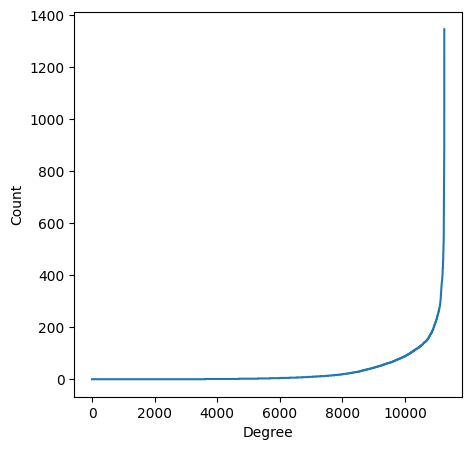

In [ ]:
statistics(g_wiki, wiki_df)

**School dataset**


NODES
Nodes :  4284

LINKS
Links :  27333
Positive Links :  15636
Negative Links :  11697

TRIADS
Triads:  15882
+++ Triad (balanced): 356
++- Triad (unbalanced): 1223
+-- Triad (balanced): 2211
--- Triad (unbalanced): 12092
None

RECIPROCATED LINKS
The total amount of reciprocated links is:  16158 ( 59.11535506530568 %)

Count of Combinations:
Positive | Positive : 10886
Positive | Negative :  822
Negative | Positive : 822
Negative | Negative : 3628

 Transforming the dataset into undirected will affect:
1644 edges ( 6.014707496432884 %)
None

DEGREE DISTRIBUTION
None


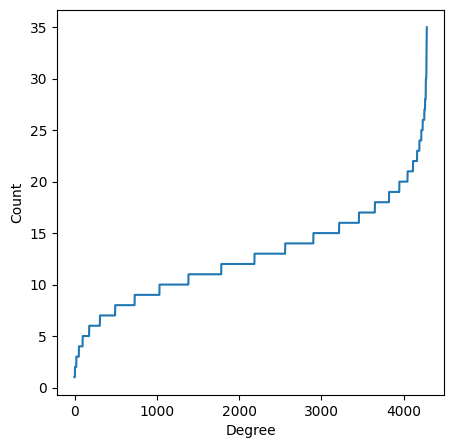

In [ ]:
statistics(g_school, school_df)

### 3.2 Visualization

In [ ]:
def network_visualization(g, name):

  """
  Make a visualization of the network, where green links are positive and red links are negative.

  Args:
    g = networkx graph

  Returns:
    visualization

  """
  plt.figure(figsize = (30, 30))
  pos = nx.spring_layout(g,
                         k = 0.15)

  # Create dictionary for the edge colours
  colors = {1: "green", -1: "red"}

  # Draw nodes
  nx.draw_networkx_nodes(g,
                        pos,
                        node_size=25,
                        node_color="black")

  # Draw edges with different colors
  for source, target, vote in g.edges(data= "VOTE"):
      edge_color = colors.get(vote, "black")
      nx.draw_networkx_edges(g,
                            pos,
                            edgelist=[(source, target)],
                            edge_color=edge_color,
                            width=1.0,
                            alpha=0.7)

  # Save as pdf
  plt.savefig(name,
              dpi = 500,
              bbox_inches = "tight")

  # Show plot
  plt.show()


**Wikipedia dataset**

In [ ]:
#network_visualization(g_wiki)

**School dataset**

In [ ]:
#network_visualization(g_school)

## 4. Preparation predictorset

### 4.1 Subgraph (computational efficiency)

In [ ]:
def snowball(graph, seed, num_layers):

    """
    Function to do snowball sampling
    1. Convert the seed to the list if input is 1 node
    2. Loop over the amount of desired layers
      - In each loop we go through one layer of nodes and find neighbours
    3. Loop over the nodes in the current layers.
      - In each loop we add the connected nodes to the sample
    4. Transform sample to a subgraph

    Args:
      g = networkx graph
      seed = the seed nodes
      num_layers = the amount of layers for snowball sampling

    Returns:
      df = pandas DataFrame
    """

    sample = set()
    visited = set(seed)
    current_layer = set(seed)

    # Convert seed to a list if it's a single node
    if isinstance(seed, str):
        seed = [seed]

    # Start snowball sampling and stop when we reach the desired number of layers
    for _ in range(num_layers):
        next_layer = set()

        # Iterate over the nodes in the current layer
        for node in current_layer:
            if node not in sample:
                sample.add(node)
                next_layer.update(graph.neighbors(node))

        # Update the current layer with the nodes in the next layer
        current_layer = next_layer - visited
        visited.update(next_layer)

    # Create a subgraph from the sample set
    sg = graph.subgraph(sample)

    # Return the sample subgraph
    return sg


**Wikipedia dataset**

In [ ]:
# Make the subset
random.seed(1307)
nodes_wiki = list(g_wiki.nodes())
seed_wiki = random.sample(nodes_wiki, 10)
sg_wiki = snowball(g_wiki, seed_wiki, 2)

# Make python dataframe from subgraph
sub_df_wiki = pd.DataFrame(sg_wiki.edges(data=True), columns=["SOURCE", "TARGET", "VOTE"])

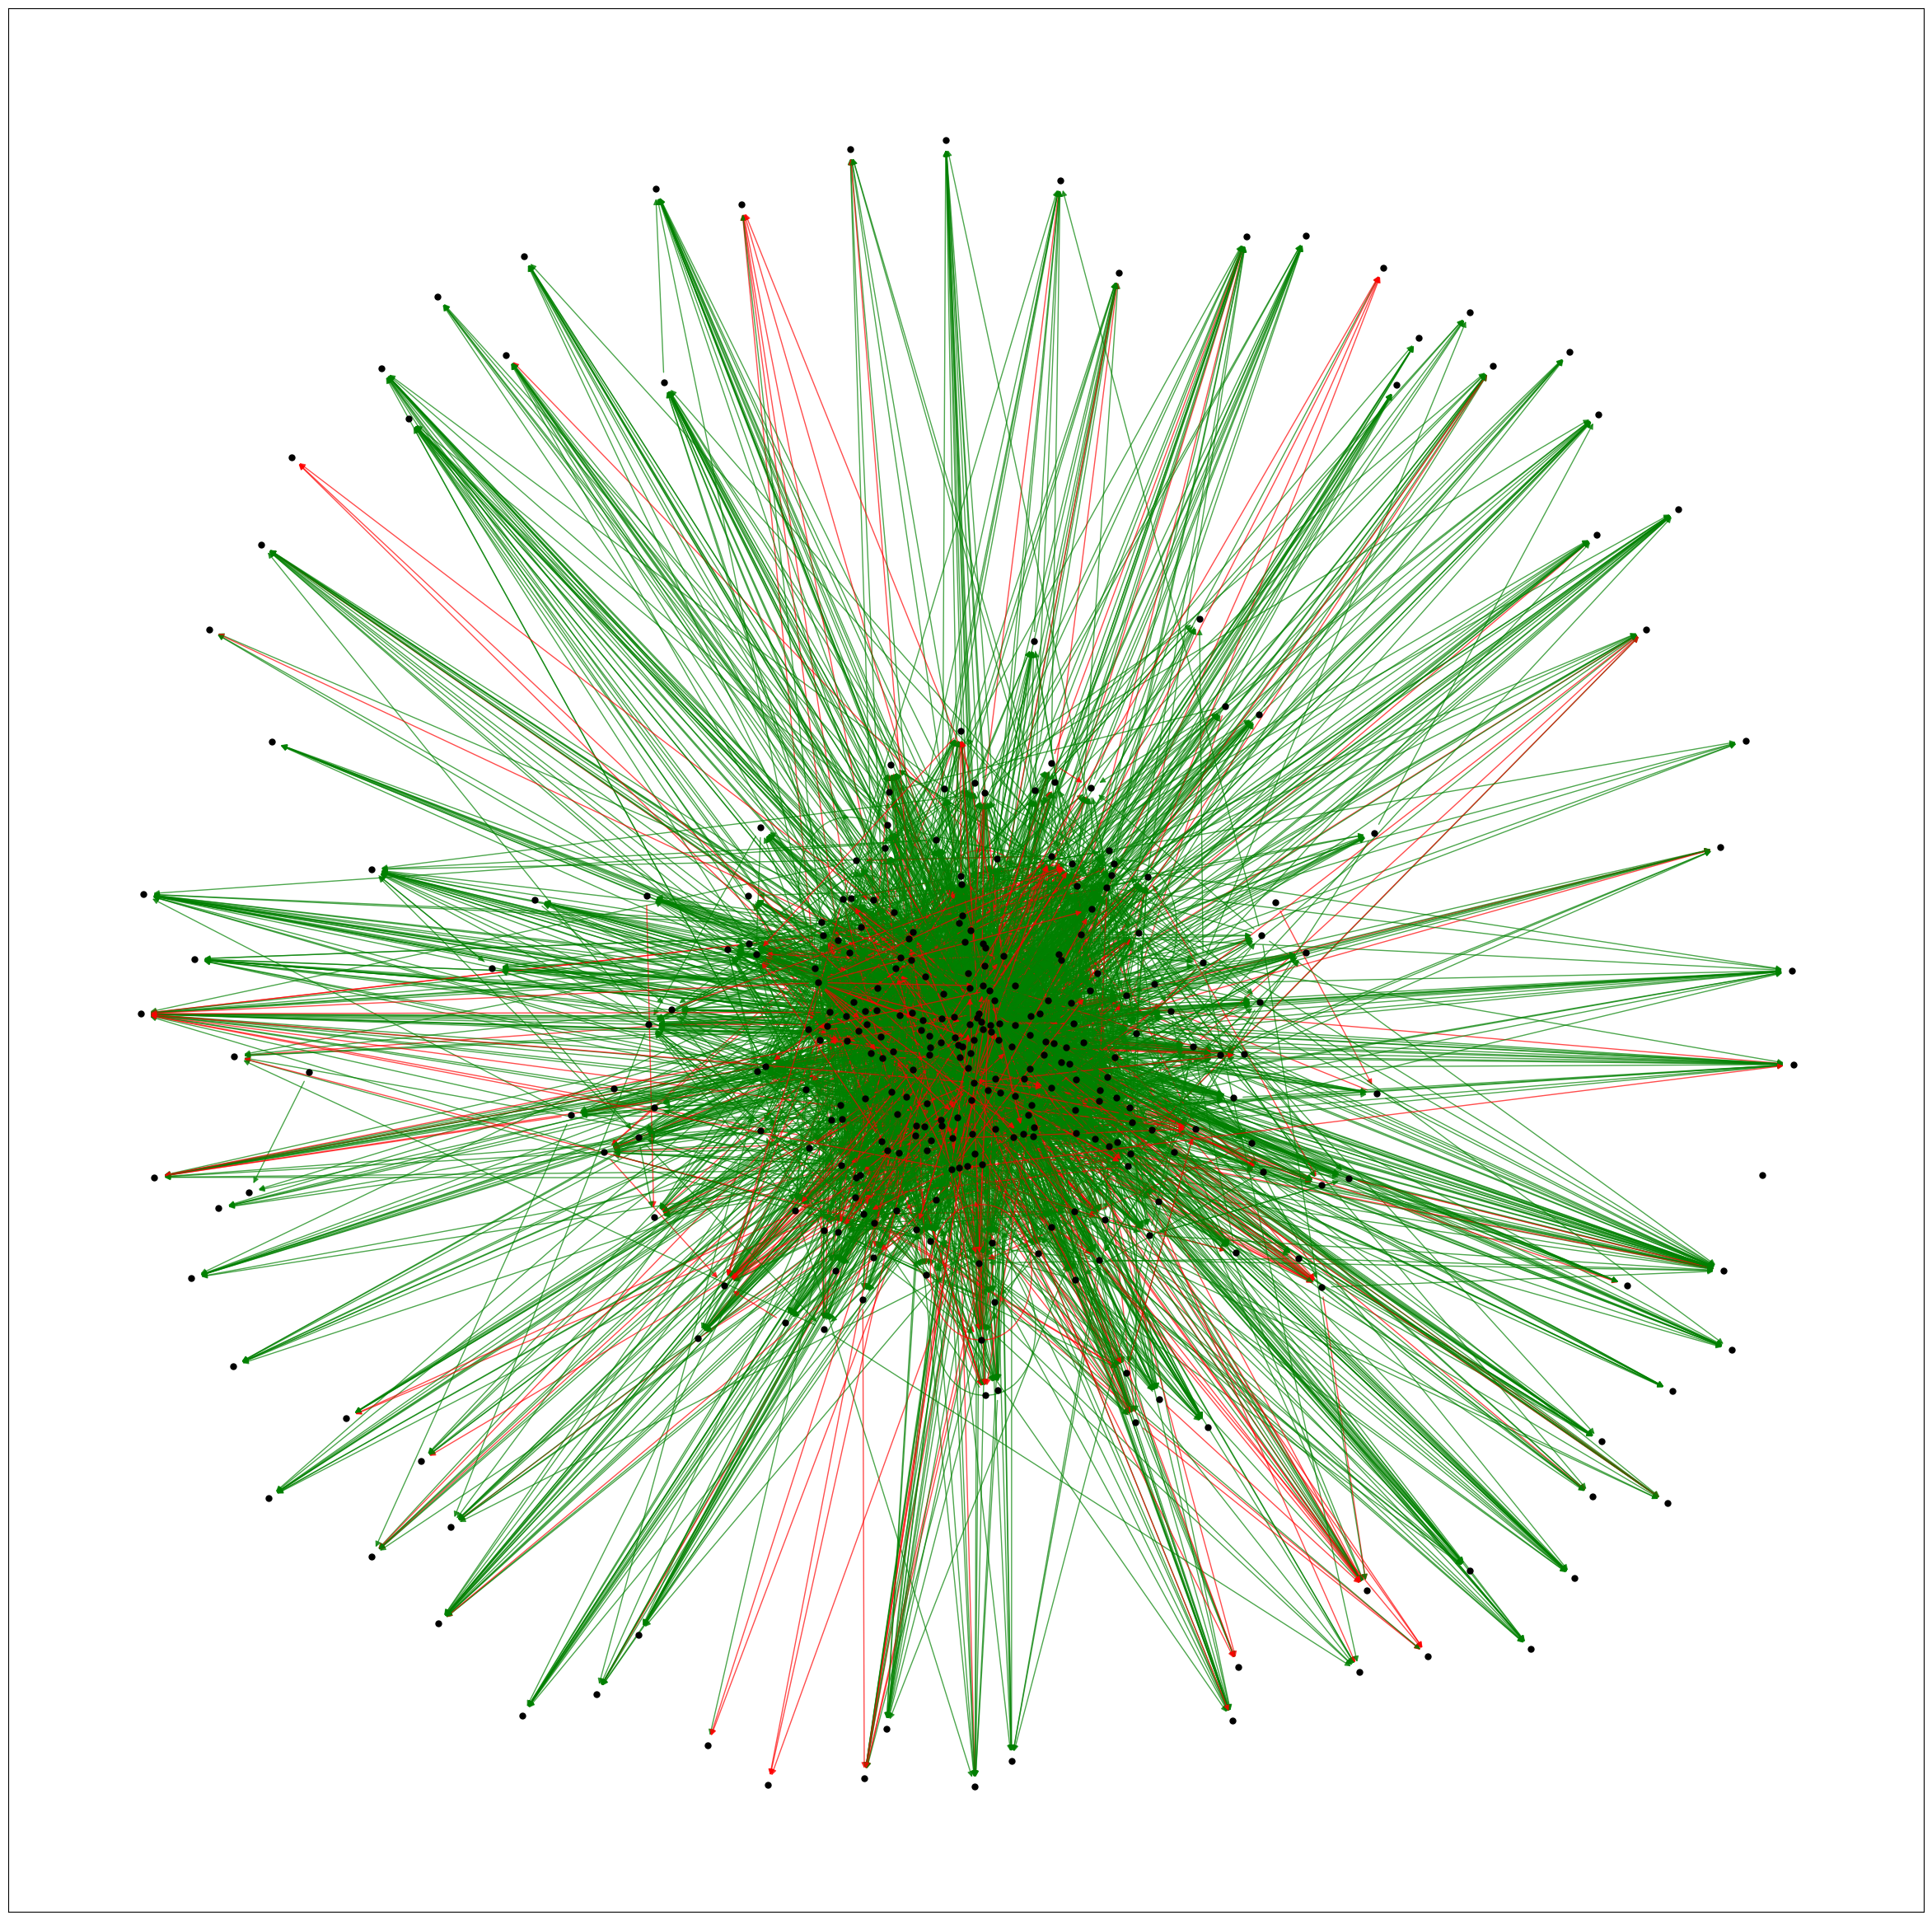

In [ ]:
network_visualization(sg_wiki, "sg_wiki.png")

**School dataset**

In [ ]:
# Make the subset
random.seed(1307)
nodes_school = list(g_school.nodes())
seed_school = random.sample(nodes_school, 10)
sg_school = snowball(g_school, seed_school, 2)

# Make python dataframe from subgraph
sub_df_school2 = pd.DataFrame(sg_school.edges(data=True), columns=["SOURCE", "TARGET", "VOTE"])

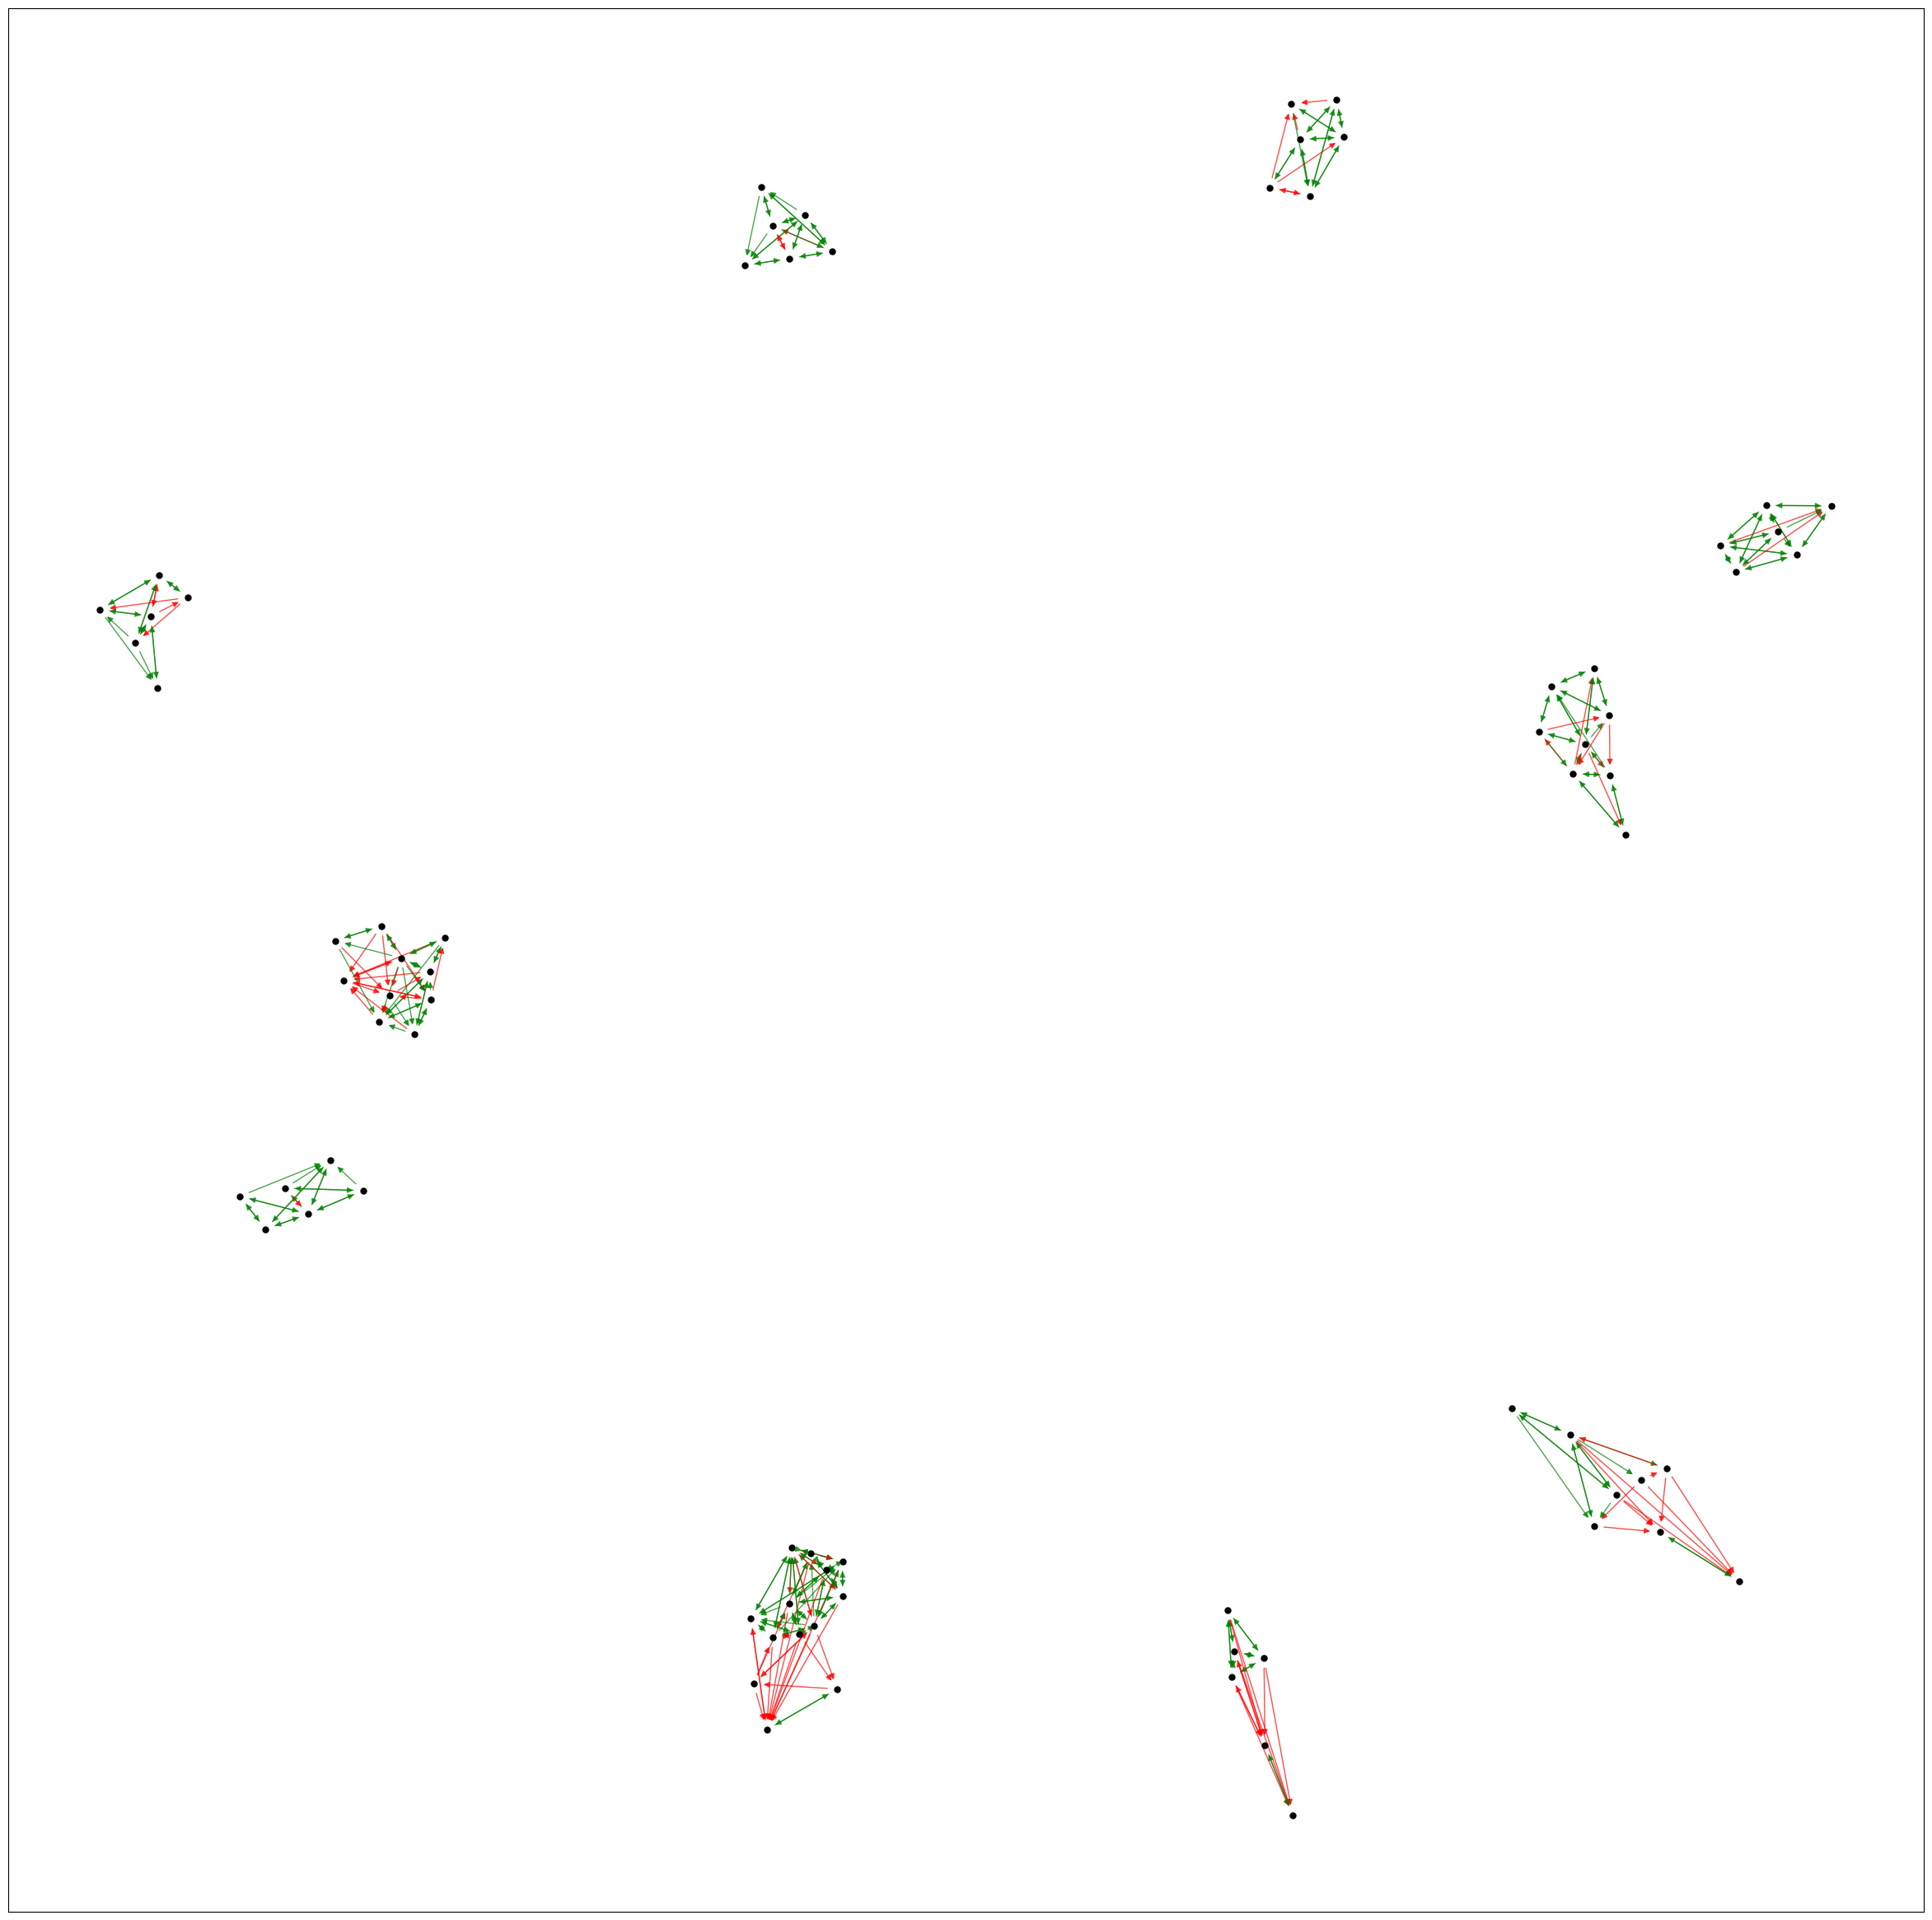

In [ ]:
network_visualization(sg_school, "sg_school.png")

### 4.2 Predictorset baseline

This is the baseline of the predictorset. It contains the right order for the indices and SOURCE and FROM nodes.

In [ ]:
def baseline(g):

  """
  Set up the baseline predictorset that includes the INDEX, SOURCE, TARGET, VOTE
    - For wikipedia dataset also DAT
    - For school dataset also CLASSID and SCHOOLID

  Args:
    g = networkx graph

  Returns:
    df = pandas DataFrame
  """

  # Extract combinations of nodes
  nodes = list(g.nodes())
  combinations = list(itertools.product(nodes, repeat = 2))

  # Create the new dataframe
  df = pd.DataFrame(combinations,
                    columns = ["SOURCE", "TARGET"])

  return df

**Wikipedia dataset**

In [ ]:
# Extract baseline predictorset
x_wiki = baseline(sg_wiki)

# Add the other predictor (DAT)
x_wiki = x_wiki.merge(wiki_full_df[["SOURCE", "TARGET", "DAT"]],
                      on = ["SOURCE", "TARGET"],
                      how = "left")
x_wiki.drop_duplicates(subset = ["SOURCE", "TARGET"],
                       inplace = True)

**School dataset**

Missing classid and schoolid due to students not being interviewed

In [ ]:
# Extract baseline predictorset
x_school = baseline(sg_school)

# Add the other predictor (CLASSID and SCHOOLID)
x_school = x_school.merge(school_df_order[["youthid", "classid", "schoolid"]],
                          left_on=["SOURCE"],
                          right_on=["youthid"],
                          how="left")
x_school.rename(columns={"classid": "CLASSID_SOURCE", "schoolid": "SCHOOLID_SOURCE"}, inplace=True)
x_school.drop(columns=["youthid"], inplace=True)
x_school = x_school.merge(school_df_order[["youthid", "classid", "schoolid"]],
                          left_on=["TARGET"],
                          right_on=["youthid"],
                          how="left")
x_school.rename(columns={"classid": "CLASSID_TARGET", "schoolid": "SCHOOLID_TARGET"}, inplace=True)
x_school.drop(columns=["youthid"], inplace=True)



### 4.3 Path-based metrics

In [ ]:
def higher_order_cycles(g, x_in):

  """
  Make all of the higher order cycles

  Args:
    g = networkx graph
    x = baseline predictors

  Return:
    Predictor dataframe (flattened A's)
    A, A^2, A^3, A^4, A^5
  """

  # Due to reciprocated edges, change network to undirected
  g_undirected = g.to_undirected()

  # Make adjecency matrix
  A = nx.to_numpy_array(g_undirected,
                        nodelist = list(g_undirected.nodes()),
                        weight = "VOTE")

  # Make higher order powers
  A2 = (A @ A)
  np.fill_diagonal(A2, 0)
  A3 = (A2 @ A)
  np.fill_diagonal(A3, 0)
  A4 = (A3 @ A)
  np.fill_diagonal(A4, 0)
  A5 = (A4 @ A)
  np.fill_diagonal(A5, 0)

  # Flatten matrices
  A = A.reshape(-1)
  A2 = A2.reshape(-1)
  A3 = A3.reshape(-1)
  A4 = A4.reshape(-1)
  A5 = A5.reshape(-1)

  # Create dictionary
  data = {"VOTE" : A,
             "A2" : A2,
             "A3" : A3,
             "A4" : A4,
             "A5" : A5}

  # Create predictor dataset
  x = pd.DataFrame(data)

  # Merge with baseline predictor dataset
  x = x_in.merge(x,
              left_index = True,
              right_index = True)

  return x, A, A2, A3, A4, A5

**Wikipedia dataset**

In [ ]:
# Extract higher order cycles
x_wiki, A_wiki, A2_wiki, A3_wiki, A4_wiki, A5_wiki = higher_order_cycles(sg_wiki, x_wiki)


**School dataset**

In [ ]:
# Extract higher order cycles
x_school, A_school, A2_school, A3_school, A4_school, A5_school = higher_order_cycles(sg_school, x_school)

### 4.4 Node-level and network-level metrics

In [ ]:
def posnegindegree(g):

  """
  Calculate the amount of positive incoming links and negative incoming links.

  Args:
    g = networkx graph

  Return:
    positive_indegrees = dictionary of positive indegree
    negative_indegrees = dictionary of negative indegree
  """

  positive_indegrees = {}
  negative_indegrees = {}

  # For loop over each node
  for i in g.nodes():

    # Extract incoming edges
    in_edges = g.in_edges(i, data = True)

    # Store amount of positive and negative edges
    positive_edges = [edge for edge in in_edges if edge[2]["VOTE"] == 1]
    negative_edges = [edge for edge in in_edges if edge[2]["VOTE"] == -1]
    positive_indegree = len(positive_edges)
    negative_indegree = len(negative_edges)
    positive_indegrees[i] = positive_indegree
    negative_indegrees[i] = negative_indegree

  return positive_indegrees, negative_indegrees

In [ ]:
def nodelevel(g, x):

  """
  Calculate all the node-level predictors: indegree, outdegree, positive and negative indegree, eigenvector and pagerank.

  Args:
    g = networkx graph

  Returns:
    df = pandas DataFrame with node-level predictors
  """

  ### INDEGREE ###
  indegree = pd.Series(dict(g.in_degree()), name="INDEGREE")

  ### OUTDEGREE ###
  outdegree = pd.Series(dict(g.out_degree()), name="OUTDEGREE")

  ### POSITIVE AND NEGATIVE INDEGREE ###
  positive_indegree, negative_indegree = posnegindegree(g)
  positive_indegree = pd.Series(positive_indegree,
                                name = "POS_INDEGREE")
  negative_indegree = pd.Series(negative_indegree,
                                name = "NEG_INDEGREE")

  ### EIGENVECTOR ###
  eigenvector = pd.Series(nx.eigenvector_centrality(g,
                                                    max_iter=1000),
                          name="EIGENVECTOR")

  ### PAGE RANK ###
  pagerank = pd.Series(nx.pagerank(g), name="PAGERANK")

  ### CLUSTERING COEFFICIENT ###
  clustering = pd.Series(nx.algorithms.cluster.clustering(g))

  ### TRANSFORM INTO DATAFRAME ###
  df = pd.DataFrame({
        "INDEGREE": indegree,
        "OUTDEGREE": outdegree,
        "POS_INDEGREE": positive_indegree,
        "NEG_INDEGREE": negative_indegree,
        "EIGENVECTOR": eigenvector,
        "PAGERANK": pagerank,
        "CLUSTERING" : clustering
    })

  df.reset_index(inplace=True)
  df.rename(columns={"index": "NODE"}, inplace=True)

  ### MERGE DATAFRAME WITH PREDICTOR SET ###
  x = x.merge(df[["NODE", "INDEGREE", "OUTDEGREE", "POS_INDEGREE", "NEG_INDEGREE", "EIGENVECTOR", "PAGERANK", "CLUSTERING"]],
              left_on="SOURCE",
              right_on="NODE",
              how="left")
  x.rename(columns={"INDEGREE": "INDEGREE_SOURCE",
                    "OUTDEGREE" : "OUTDEGREE_SOURCE",
                    "POS_INDEGREE" : "POS_INDEGREE_SOURCE",
                    "NEG_INDEGREE" : "NEG_INDEGREE_SOURCE",
                    "EIGENVECTOR" : "EIGENVECTOR_SOURCE",
                    "PAGERANK" : "PAGERANK_SOURCE",
                    "CLUSTERING" : "CLUSTERING_SOURCE"},
                inplace=True)
  x.drop(columns=["NODE"],
              inplace=True)
  x = x.merge(df[["NODE", "INDEGREE", "OUTDEGREE", "POS_INDEGREE", "NEG_INDEGREE", "EIGENVECTOR", "PAGERANK", "CLUSTERING"]],
              left_on="TARGET",
              right_on="NODE",
              how="left")
  x.rename(columns={"INDEGREE": "INDEGREE_TARGET",
                    "OUTDEGREE" : "OUTDEGREE_TARGET",
                    "POS_INDEGREE" : "POS_INDEGREE_TARGET",
                    "NEG_INDEGREE" : "NEG_INDEGREE_TARGET",
                    "EIGENVECTOR" : "EIGENVECTOR_TARGET",
                    "PAGERANK" : "PAGERANK_TARGET",
                    "CLUSTERING" : "CLUSTERING_TARGET"},
                inplace=True)
  x.drop(columns=["NODE"],
              inplace=True)

  return x

**Wikipedia dataset**

In [ ]:
# Add node level predictors to existing predictor set
x_wiki = nodelevel(sg_wiki, x_wiki)

**School dataset**

In [ ]:
# Add node level predictors to existing predictor set
x_school = nodelevel(sg_school, x_school)


### 4.5 Similarity-based metrics

In [ ]:
def common_neighbors(g):

  """
  Calculate the common neighbors index.

  Args:
    g = networkx graph

  Return:
    list with two nodes and common neighbors score
  """

  common_neighbors_list = []

  # Loop over every node
  for u in g.nodes():
      # Get their neighbors
      neighbors1 = set(g.neighbors(u))
      # Loop over every other node
      for v in g.nodes():
          # Check if the nodes are not the same
          if u != v:
              # Get their neighbors
              neighbors2 = set(g.neighbors(v))
              # Calculate the common neighbors score
              similarity = len(neighbors1.intersection(neighbors2))
              common_neighbors_list.append((u, v, similarity))

  return common_neighbors_list

In [ ]:
def salton_index(g):

  """
  Calculate the salton index / cosine similarity score.

  Args:
    g = networkx graph

  Return:
    list with the two nodes and their salton index score
  """
  salton_indices = []

  # Loop over every node
  for u in g.nodes():
    # Get their neighbors
    neighbors1 = set(g.neighbors(u))
    # Loop over every other node
    for v in g.nodes():
      # Check if the nodes are not the same
      if u != v:
        # Get their neighbors
        neighbors2 = set(g.neighbors(v))
        # Calculate the salton index / cosine similarity
        if neighbors1 and neighbors2:
          intersection = neighbors1.intersection(neighbors2)
          similarity = len(intersection) / (len(neighbors1) * len(neighbors2)) ** 0.5
          # Add the nodes + similarity score to salton index list
          salton_indices.append((u, v, similarity))
        else:
          # If nodes do not share neighbors, return 0
          salton_indices.append((u, v, 0))

  return salton_indices

In [ ]:
def sorensen_index(g):
  """
  Calculate the sorensen index score.

  Args:
    g = networkx graph

  Return:
    list with the two nodes and their sorensen index score
  """
  sorensen_index = []

  # Loop over every node
  for u in g.nodes():
    # Get their neighbors
    neighbors1 = set(g.neighbors(u))
    # Loop over every other node
    for v in g.nodes():
      # Check if the nodes are not the same
      if u != v:
        # Get their neighbors
        neighbors2 = set(g.neighbors(v))
        # Calculate the salton index / cosine similarity
        if neighbors1 and neighbors2:
          intersection = neighbors1.intersection(neighbors2)
          similarity = 2 * len(intersection) / (len(neighbors1) + len(neighbors2))
          # Add the nodes + similarity score to sorensen index list
          sorensen_index.append((u, v, similarity))
        else:
          # If nodes do not share neighbors, return 0
          sorensen_index.append((u, v, 0))

  return sorensen_index

In [ ]:
def hub_promoted_index(g):
  """
  Calculate the hub promoted index score.

  Args:
    g = networkx graph

  Return:
    list with the two nodes and their hub promoted index score.
  """
  hpi_index = []

  # Loop over every node
  for u in g.nodes():
    # Get their neighbors
    neighbors1 = set(g.neighbors(u))
    # Loop over every other node
    for v in g.nodes():
      # Check if the nodes are not the same
      if u != v:
        # Get their neighbors
        neighbors2 = set(g.neighbors(v))
        # Calculate the hpi score
        if neighbors1 and neighbors2:
          intersection = neighbors1.intersection(neighbors2)
          similarity = len(intersection) / min(len(neighbors1), len(neighbors2))
          # Add the nodes + similarity score to hpi list
          hpi_index.append((u, v, similarity))
        else:
          # If nodes do not share neighbors, return 0
          hpi_index.append((u, v, 0))

  return hpi_index

In [ ]:
def hub_depressed_index(g):
  """
  Calculate the hub depressed index score.

  Args:
    g = networkx graph

  Return:
    list with the two nodes and their hub depressed index score.
  """
  hdi_index = []

  # Loop over every node
  for u in g.nodes():
    # Get their neighbors
    neighbors1 = set(g.neighbors(u))
    # Loop over every other node
    for v in g.nodes():
      # Check if the nodes are not the same
      if u != v:
        # Get their neighbors
        neighbors2 = set(g.neighbors(v))
        # Calculate the hdi score
        if neighbors1 and neighbors2:
          intersection = neighbors1.intersection(neighbors2)
          similarity = len(intersection) / max(len(neighbors1), len(neighbors2))
          # Add the nodes + similarity score to hdi list
          hdi_index.append((u, v, similarity))
        else:
          # If nodes do not share neighbors, return 0
          hdi_index.append((u, v, 0))

  return hdi_index

In [ ]:
def linkprediction(g):

  """
  Calculate the link prediction scores and add to current predictor set:
    Common Neighbors
    Salton Index
    Jaccard Similarity
    Sorensen Index
    Hub Promoted Index
    Hub Depressed Index
    Preferential Attachment
    Adamic Adar Index
    Resource Allocation Index

  Args:
    g = networkx graph
    x = predictor dataset (DataFrame)

  Return:
    x = predictor dataset (DataFrame)
  """

  # Change graph to undirected
  g_undirected = g.to_undirected()

  # Extract all possible edges
  index = list(itertools.combinations(g_undirected.nodes(), 2))
  edges = [tuple(x) for x in index]
  reversed_edges = [(edge[1], edge[0]) for edge in edges]

  ### COMMON NEIGHBORS ###
  cn = list(common_neighbors(g))

  #### SALTON INDEX ###
  salton = salton_index(g)

  ### JACCARD INDEX ###
  jaccard = list(nx.jaccard_coefficient(g_undirected, edges)) + list(nx.jaccard_coefficient(g_undirected, reversed_edges))

  ### SORENSEN INDEX ###
  sorensen = sorensen_index(g)

  ### HUB PROMOTED INDEX ###
  hpi = hub_promoted_index(g)

  ### HUB DEPRESSED INDEX ###
  hdi = hub_depressed_index(g)

  ### PREFERENTIAL ATTACHMENT ###
  pa = list(nx.preferential_attachment(g_undirected, edges)) + list(nx.preferential_attachment(g_undirected, reversed_edges))

  ### ADAMIC-ADAR INDEX ###
  aa = list(nx.adamic_adar_index(g_undirected, edges)) + list(nx.adamic_adar_index(g_undirected, reversed_edges))

  ### RESOURCE ALLOCATION INDEX ###
  ra = list(nx.resource_allocation_index(g_undirected, edges)) + list(nx.resource_allocation_index(g_undirected, reversed_edges))

  ### TRANSFORM INTO DATAFRAME ###
  df = pd.DataFrame({
      "SOURCE" : list(zip(*cn))[0],
      "TARGET" : list(zip(*cn))[1],
      "CN" : list(zip(*cn))[2],
      "SALTON" : list(zip(*salton))[2],
      "JACCARD" : list(zip(*jaccard))[2],
      "SORENSEN" : list(zip(*sorensen))[2],
      "HPI" : list(zip(*hpi))[2],
      "HDI" : list(zip(*hdi))[2],
      "PA" : list(zip(*pa))[2],
      "AA" : list(zip(*aa))[2],
      "RA" : list(zip(*ra))[2]
    })

  return df


**Wikipedia Dataset**

In [ ]:
# Combine link prediction dataset with predictor set
wiki_link = linkprediction(sg_wiki)
x_wiki = pd.merge(x_wiki,
                  wiki_link,
                  on = ["SOURCE", "TARGET"])


**School Dataset**

In [ ]:
school_link = linkprediction(sg_school)

# Make sure that both columns are integers
school_link["SOURCE"] = school_link["SOURCE"].astype(int)
school_link["TARGET"] = school_link["TARGET"].astype(int)
x_school["SOURCE"] = x_school["SOURCE"].astype(int)
x_school["TARGET"] = x_school["TARGET"].astype(int)

# Combine link prediction dataset with predictor set
x_school = pd.merge(x_school,
                    school_link,
                    on = ["SOURCE", "TARGET"])

### 4.6 Social theory metrics

The following social status theory predictors can be applied to both datasets:

$\sum (eigenvector * positive  ties) - (eigenvector * negative ties)$

In [ ]:
def social_status(x):

  """
  Calculate the social status based on the eigenvector, positive indegree and negative indegree.

  Args:
    x = DataFrame

  Return:
    x = two lists with the social status for source and target node
  """

  # Calculate metrics
  eigenvector_source = x["EIGENVECTOR_SOURCE"]
  indegree_pos = x["POS_INDEGREE_SOURCE"]
  indegree_neg = x["NEG_INDEGREE_SOURCE"]
  eigenvector_target = x["EIGENVECTOR_TARGET"]
  indegree_pos_t = x["POS_INDEGREE_TARGET"]
  indegree_neg_t = x["NEG_INDEGREE_TARGET"]

  # Calculate social status
  ss_source = (eigenvector_source * indegree_pos) - (eigenvector_source * indegree_neg)
  ss_target = (eigenvector_target * indegree_pos_t) - (eigenvector_target * indegree_neg_t)

  # Store in array
  socialstatus_source = np.array(ss_source)
  socialstatus_target = np.array(ss_target)

  return socialstatus_source, socialstatus_target


**Wikipedia dataset**

In this dataset we have as an extra predictor the social balance based on a time component. The earlier the node can vote, the higher their status.

In [ ]:
def date(datetime_str):

  """
  Transform a hh:mm dd:mm:yyyy format into a dd:mm:yyyy format.

  Args:
    datetime_str  A datetime component

  Return:
    the right format or NaT (Not A Time)
  """
  if isinstance(datetime_str, float):  # Check if the value is a float
    return pd.NaT  # Return missing value
  try:
    datetime_parts = datetime_str.split(", ")
    date_str = datetime_parts[1]
    return pd.to_datetime(date_str, format="%d %B %Y").date()
  except (ValueError, IndexError):
    return pd.NaT

def socialstatus_time(x, source, dat):

  """
  First extracts the earliest date that somebody has voted.
  Then assigns weights for each node on how early they have voted for the first time.
  The earlier the first date, the higher the weight, the higher the status.

  Args:
    x = DataFrame
    source = "SOURCE" variable
    dat = "DAT" variable

  Return:
    weights = dictionary with node name + assigned weight
  """

  first_date = {}
  weights = {}

  # Loop over each node and extract the first time they have voted
  for i in x[source].unique():

    # Extract the earliest date for a specific node
    i_x = x[x[source] == i].sort_values(by = dat)
    earliest_date =  i_x.iloc[0][dat]
    first_date[i] = earliest_date

  # Make weights: the earlier the date the higher the weight
  sorted_dates = sorted(first_date.items(),
                        key = lambda x: x[1])

  for i, (source, dat) in enumerate(sorted_dates):
    weight = i + 1
    weights[source] = weight


  return weights


In [ ]:
### TIME COMPONENT ###
# Transform DAT variable to right dd:mm:yyyy
x_wiki["DAT"] = x_wiki["DAT"].apply(date)

# Add predictor for socialstatus_time
ss_time = socialstatus_time(x_wiki, "SOURCE", "DAT")
ss_time = pd.DataFrame.from_dict(ss_time,
                                 orient = "index",
                                 columns = ["weight"])
x_wiki["SS_TIME_SOURCE"] = x_wiki["SOURCE"].map(ss_time.weight)
x_wiki["SS_TIME_TARGET"] = x_wiki["TARGET"].map(ss_time.weight)


# Fill the NaN's with 0 in the columns
x_wiki["SS_TIME_SOURCE"].fillna(0, inplace=True)
x_wiki["SS_TIME_TARGET"].fillna(0, inplace=True)


### SOCIAL STATUS THEORY ###
socialstatus_source_wiki, socialstatus_target_wiki = social_status(x_wiki)

# Add two new variables to the dataframe
x_wiki["SOCIALSTATUS_SOURCE"] = socialstatus_source_wiki
x_wiki["SOCIALSTATUS_TARGET"] = socialstatus_target_wiki


<ipython-input-64-01a70430a672>:49: FutureWarning: Comparison of NaT with datetime.date is deprecated in order to match the standard library behavior. In a future version these will be considered non-comparable.
  sorted_dates = sorted(first_date.items(),


**School dataset**

In this dataset we have as an extra predictor the social balance based on popularity. Each node has voted for the most popular student. The student with the highest votes has the highest popularity.

In [ ]:
def popular(df, x):

  """
  Adds the popularity score for each student to the column by counting how many times
  another student has selected them as the most popular student. The higher the number,
  the more popular the student. This will be added as a new predictor to the existing
  predictor set x.

  Args:
    df = DataFrame with the popularity votes for each student
    x = DataFrame with predictorset

  Returns:
    x = DataFrame with predictorset with new variables

  """

  # Calculate the value counts of each column
  pop1 = df["y1_pos_1"].value_counts()
  pop2 = df["y1_pos_2"].value_counts()
  pop3 = df["y1_pos_3"].value_counts()
  pop4 = df["y1_pos_4"].value_counts()
  pop5 = df["y1_pos_5"].value_counts()

  # Merge the counts
  merged_counts = pop1.add(pop2, fill_value=0).add(pop3, fill_value=0).add(pop4, fill_value=0).add(pop5, fill_value=0)

  # Add these new popularity counts to the predictor set x
  x["SS_POPULARITY_SOURCE"] = x["SOURCE"].map(merged_counts)
  x["SS_POPULARITY_TARGET"] = x["TARGET"].map(merged_counts)

  # Fill the NaN's with 0 in the columns
  x["SS_POPULARITY_SOURCE"].fillna(0, inplace=True)
  x["SS_POPULARITY_TARGET"].fillna(0, inplace=True)

  return x


In [ ]:
## SOCIAL STATUS POPULARITY ###
x_school = popular(school_df_popular, x_school)

### SOCIAL STATUS THEORY ###
socialstatus_source_school, socialstatus_target_school = social_status(x_school)

# Add two new variables to the dataframe
x_school["SOCIALSTATUS_SOURCE"] = socialstatus_source_school
x_school["SOCIALSTATUS_TARGET"] = socialstatus_target_school


### 4.7 Delete edges from same class ID

In [ ]:
x_school = delete_same_class(x_school)

### 4.8 Final predictor sets

In [ ]:
print("\n WIKIPEDIA SUBSET DATASET: ")
x_wiki.head()


 WIKIPEDIA SUBSET DATASET: 


SOURCE            TARGET         DAT  VOTE    A2      A3       A4  \
0  Dlohcierekim           Snowolf         NaT   0.0   7.0   608.0  27394.0   
1  Dlohcierekim  StephenHjellum13         NaT   0.0  -2.0   -60.0  -3000.0   
2  Dlohcierekim           GDonato         NaT   0.0  17.0  1063.0  51016.0   
3  Dlohcierekim           Citicat         NaT   0.0   6.0   396.0  16841.0   
4  Dlohcierekim         Jehochman  2007-10-06   1.0   8.0   687.0  28732.0   

          A5  INDEGREE_SOURCE  OUTDEGREE_SOURCE  ...  SORENSEN       HPI  \
0  1336231.0               20               109  ...  0.133333  0.346154   
1  -147232.0               20               109  ...  0.000000  0.000000   
2  2483268.0               20               109  ...  0.225000  0.352941   
3   844027.0               20               109  ...  0.084034  0.500000   
4  1395118.0               20               109  ...  0.217687  0.421053   

        HDI    PA        AA        RA  SS_TIME_SOURCE  SS_TIME_TARGET  \
0  0.082569  4522  4.148611  0.308858               1             6.0   
1  0.000000   357  0.440217  0.021279               1             7.0   
2  0.165138  6902  5.368148  0.342149               1            18.0   
3  0.045872  2261  2.409929  0.183685               1            24.0   
4  0.146789  5355  5.504097  0.448614               1            15.0   

   SOCIALSTATUS_SOURCE  SOCIALSTATUS_TARGET  
0              1.08301             0.604780  
1              1.08301            -0.022605  
2              1.08301             0.698221  
3              1.08301             0.103755  
4              1.08301             0.479900  

[5 rows x 35 columns]

In [ ]:
print("\n SCHOOL SUBSET DATASET: ")
x_school.head()


 SCHOOL SUBSET DATASET: 


SOURCE    TARGET  CLASSID_SOURCE  SCHOOLID_SOURCE  CLASSID_TARGET  \
0   30520320  30520321          305203             3052          305203   
58  30520320  30520301          305203             3052          305203   
61  30520320  30520302          305203             3052          305203   
63  30520320  30520304          305203             3052          305203   
65  30520320  30520310          305203             3052          305203   

    SCHOOLID_TARGET  VOTE   A2   A3    A4  ...  SORENSEN       HPI       HDI  \
0              3052   1.0  1.0  2.0  13.0  ...  0.600000  1.000000  0.428571   
58             3052   0.0  1.0  2.0  12.0  ...  0.500000  0.666667  0.400000   
61             3052   0.0  0.0  3.0   6.0  ...  0.333333  0.333333  0.333333   
63             3052  -1.0  0.0 -1.0   3.0  ...  0.333333  0.333333  0.333333   
65             3052  -1.0  0.0 -2.0  -6.0  ...  0.000000  0.000000  0.000000   

    PA        AA        RA  SS_POPULARITY_SOURCE  SS_POPULARITY_TARGET  \
0   28  1.964017  0.650000                   9.0                   1.0   
58  20  1.756568  0.542857                   9.0                   0.0   
61  12  1.135233  0.342857                   9.0                   0.0   
63  16  1.135233  0.342857                   9.0                   0.0   
65  20  1.235246  0.392857                   9.0                   0.0   

    SOCIALSTATUS_SOURCE  SOCIALSTATUS_TARGET  
0          3.165796e-11         1.691915e-10  
58         3.165796e-11         1.011802e-10  
61         3.165796e-11         1.011802e-10  
63         3.165796e-11         0.000000e+00  
65         3.165796e-11        -4.016670e-10  

[5 rows x 38 columns]

In [ ]:
print("\n WIKIPEDIA DATASET PREDICTORS: ")
print(x_wiki.columns)
print("\n SCHOOL DATASET PREDICTORS: ")
print(x_school.columns)


 WIKIPEDIA DATASET PREDICTORS: 
Index(['SOURCE', 'TARGET', 'DAT', 'VOTE', 'A2', 'A3', 'A4', 'A5',
       'INDEGREE_SOURCE', 'OUTDEGREE_SOURCE', 'POS_INDEGREE_SOURCE',
       'NEG_INDEGREE_SOURCE', 'EIGENVECTOR_SOURCE', 'PAGERANK_SOURCE',
       'CLUSTERING_SOURCE', 'INDEGREE_TARGET', 'OUTDEGREE_TARGET',
       'POS_INDEGREE_TARGET', 'NEG_INDEGREE_TARGET', 'EIGENVECTOR_TARGET',
       'PAGERANK_TARGET', 'CLUSTERING_TARGET', 'CN', 'SALTON', 'JACCARD',
       'SORENSEN', 'HPI', 'HDI', 'PA', 'AA', 'RA', 'SS_TIME_SOURCE',
       'SS_TIME_TARGET', 'SOCIALSTATUS_SOURCE', 'SOCIALSTATUS_TARGET'],
      dtype='object')

 SCHOOL DATASET PREDICTORS: 
Index(['SOURCE', 'TARGET', 'CLASSID_SOURCE', 'SCHOOLID_SOURCE',
       'CLASSID_TARGET', 'SCHOOLID_TARGET', 'VOTE', 'A2', 'A3', 'A4', 'A5',
       'INDEGREE_SOURCE', 'OUTDEGREE_SOURCE', 'POS_INDEGREE_SOURCE',
       'NEG_INDEGREE_SOURCE', 'EIGENVECTOR_SOURCE', 'PAGERANK_SOURCE',
       'CLUSTERING_SOURCE', 'INDEGREE_TARGET', 'OUTDEGREE_TARGET',
     

In [ ]:
# Save as csv for computational reasons
path = "/content/drive/My Drive/x_wiki.csv"
x_wiki.to_csv(path,
              index = False)

# Save as csv for computational reasons
path = "/content/drive/My Drive/x_school.csv"
x_school.to_csv(path,
                index = False)

## 5. Data Analysis

### 5.1 Settings for K-fold cross validation

In [ ]:
### LOAD DATASET ###
path = "/content/drive/My Drive/x_wiki.csv"
x_wiki = pd.read_csv(path)
path = "/content/drive/My Drive/x_school.csv"
x_school = pd.read_csv(path)


**Wikipedia dataset**

In [ ]:
# Extract feature components
Y_wiki = x_wiki.pop("VOTE")
X_wiki = x_wiki.drop(columns = ["SOURCE", "TARGET", "DAT"]) #drop irrelevant columns and columns with missing variables

# Set number of folds
k = 5

**School dataset**

In [ ]:
# Extract feature components
Y_school = x_school.pop("VOTE")
X_school = x_school.drop(columns = ["SOURCE", "TARGET", "CLASSID_TARGET", "SCHOOLID_SOURCE", "SCHOOLID_TARGET"]) #drop irrelevant columns and columns with missing variables


### 5.2 Account for imbalance

**Wikipedia dataset**

In [ ]:
### SUBSET ###
# Convert class labels to integers
class_labels = np.unique(Y_wiki)
label_mapping = {label: i for i, label in enumerate(class_labels)}
Y_wiki_int = np.array([label_mapping[label] for label in Y_wiki])

# Compute class counts
class_counts = np.bincount((Y_wiki_int))  # Use absolute values for computing class counts

# Compute total number of samples
total_samples = np.sum(class_counts)

# Define the weights for the model for each class
weights_wiki = {label: total_samples / count for label, count in zip(class_labels, class_counts)}

**School dataset**

In [ ]:
### SUBSET ###
# Convert class labels to integers
class_labels = np.unique(Y_school)
label_mapping = {label: i for i, label in enumerate(class_labels)}
Y_school_int = np.array([label_mapping[label] for label in Y_school])

# Compute class counts
class_counts = np.bincount((Y_school_int))  # Use absolute values for computing class counts

# Compute total number of samples
total_samples = np.sum(class_counts)

# Define the weights for the model for each class
weights_school = {label: total_samples / count for label, count in zip(class_labels, class_counts)}

### 5.3 Model creation and tuning on subsets

The difference between cv_comparison_wiki and cv_comparison_school is that for the school network, the folds are created based on the classID and for wikipedia this is random.

In [ ]:
def cv_comparison_wiki(models, X, y, cv):

    """
    Do a K-fold cross validation between multiple models.

    Args:
      models = different models
      X = predictor set
      y = target variable
      cv = CrossValidation method

    Return:
      cv_metrics = DataFrame with performance measurements
      metrics = array with raw results
    """
    # Initialize a DataFrame for the averages and a list for all measures
    cv_metrics = pd.DataFrame()
    metrics = []

    # Define the scoring metrics
    scoring = {
        "precision_class_-1": make_scorer(precision_score, average=None, labels=[-1]),
        "precision_class_0": make_scorer(precision_score, average=None, labels=[0]),
        "precision_class_1": make_scorer(precision_score, average=None, labels=[1]),
        "recall_class_-1": make_scorer(recall_score, average=None, labels=[-1]),
        "recall_class_0": make_scorer(recall_score, average=None, labels=[0]),
        "recall_class_1": make_scorer(recall_score, average=None, labels=[1]),
        "f1_macro": make_scorer(precision_score, average="macro"),
        "f1": make_scorer(f1_score, average="weighted"),
        "accuracy": make_scorer(accuracy_score)
    }

    # Loop through the models, run a CV, add the average scores to the DataFrame and the scores of
    # all CVs to the list
    for model in models:
        # Perform cross-validation
        scores = cross_validate(model, X, y, scoring=scoring, cv=cv, n_jobs = -1)

        # Extract the metric scores
        precision_class_minus_1 = np.round(scores["test_precision_class_-1"].mean(), 4)
        precision_class_0 = np.round(scores["test_precision_class_0"].mean(), 4)
        precision_class_1 = np.round(scores["test_precision_class_1"].mean(), 4)
        recall_class_minus_1 = np.round(scores["test_recall_class_-1"].mean(), 4)
        recall_class_0 = np.round(scores["test_recall_class_0"].mean(), 4)
        recall_class_1 = np.round(scores["test_recall_class_1"].mean(), 4)
        f1_macro = np.round(scores["test_f1_macro"].mean(), 4)
        f1 = np.round(scores["test_f1"].mean(), 4)
        accuracy = np.round(scores["test_accuracy"].mean(), 4)

        # Add the metric scores to the DataFrame
        cv_metrics[str(model)] = [
            precision_class_minus_1,
            precision_class_0,
            precision_class_1,
            recall_class_minus_1,
            recall_class_0,
            recall_class_1,
            f1_macro,
            f1,
            accuracy
        ]

        # Add the metric scores to the list
        metrics.append(scores)

    cv_metrics.index = ["Precision_class_-1", "Precision_class_0", "Precision_class_1",
                    "Recall_class_-1", "Recall_class_0", "Recall_class_1",
                    "F1 Macro", "F1", "Accuracy"]

    return cv_metrics, metrics


In [ ]:
def cv_comparison_school(models, X, y, cv):

    """
    Do a K-fold cross validation between multiple models.

    Args:
      models = different models
      X = predictor set
      y = target variable
      cv = CrossValidation method

    Return:
      cv_metrics = DataFrame with performance measurements
      metrics = array with raw results
    """
    # Initialize a DataFrame for the averages and a list for all measures
    cv_metrics = pd.DataFrame()
    metrics = []

    # Define the scoring metrics
    scoring = {
        "precision_class_-1": make_scorer(precision_score, average=None, labels=[-1]),
        "precision_class_0": make_scorer(precision_score, average=None, labels=[0]),
        "precision_class_1": make_scorer(precision_score, average=None, labels=[1]),
        "recall_class_-1": make_scorer(recall_score, average=None, labels=[-1]),
        "recall_class_0": make_scorer(recall_score, average=None, labels=[0]),
        "recall_class_1": make_scorer(recall_score, average=None, labels=[1]),
        "f1_macro": make_scorer(precision_score, average="macro"),
        "f1": make_scorer(f1_score, average="weighted"),
        "accuracy": make_scorer(accuracy_score)
    }

    #Extract classID
    class_id = X["CLASSID_SOURCE"]

    # Loop through the models, run a CV, add the average scores to the DataFrame and the scores of
    # all CVs to the list
    for model in models:
        # Perform cross-validation
        scores = cross_validate(model, X, y, scoring=scoring, cv=cv.split(X, class_id), n_jobs = -1)

        # Extract the metric scores
        precision_class_minus_1 = np.round(scores["test_precision_class_-1"].mean(), 4)
        precision_class_0 = np.round(scores["test_precision_class_0"].mean(), 4)
        precision_class_1 = np.round(scores["test_precision_class_1"].mean(), 4)
        recall_class_minus_1 = np.round(scores["test_recall_class_-1"].mean(), 4)
        recall_class_0 = np.round(scores["test_recall_class_0"].mean(), 4)
        recall_class_1 = np.round(scores["test_recall_class_1"].mean(), 4)
        f1_macro = np.round(scores["test_f1_macro"].mean(), 4)
        f1 = np.round(scores["test_f1"].mean(), 4)
        accuracy = np.round(scores["test_accuracy"].mean(), 4)

        # Add the metric scores to the DataFrame
        cv_metrics[str(model)] = [
            precision_class_minus_1,
            precision_class_0,
            precision_class_1,
            recall_class_minus_1,
            recall_class_0,
            recall_class_1,
            f1_macro,
            f1,
            accuracy
        ]

        # Add the metric scores to the list
        metrics.append(scores)

    cv_metrics.index = ["Precision_class_-1", "Precision_class_0", "Precision_class_1",
                    "Recall_class_-1", "Recall_class_0", "Recall_class_1",
                    "F1 Macro", "F1", "Accuracy"]

    return cv_metrics, metrics


In [ ]:
# Make the stratified kfold component
skf = StratifiedKFold(n_splits = k,
                      shuffle = True,
                      random_state = 42)

**Wikipedia dataset**

In [ ]:
# Make logistic regression model
lm_wiki = LogisticRegression(multi_class = "multinomial",
                        solver = "saga",
                        class_weight = weights_wiki,
                        max_iter = 10000)

# Make LGBM model
lgbm_wiki = lgb.LGBMClassifier(n_estimators = 1000,
                                 class_weight = weights_wiki)

# Define the models
models_wiki = [lm_wiki, lgbm_wiki]

# Analysis
cv_metrics_wiki, metrics_wiki = cv_comparison_wiki(models_wiki, X_wiki, Y_wiki, skf)

In [ ]:
# Print the results
cv_metrics_wiki

LogisticRegression(class_weight={-1.0: 83.54211663066954,\n                                 0.0: 1.1067872267368661,\n                                 1.0: 11.832364637503824},\n                   max_iter=10000, multi_class='multinomial', solver='saga')  \
Precision_class_-1                                             0.0122                                                                                                                                                                                                                
Precision_class_0                                              0.9575                                                                                                                                                                                                                
Precision_class_1                                              0.2157                                                                                                                                                                                                                
Recall_class_-1                                                0.3182                                                                                                                                                                                                                
Recall_class_0                                                 0.4214                                                                                                                                                                                                                
Recall_class_1                                                 0.7393                                                                                                                                                                                                                
F1 Macro                                                       0.3951                                                                                                                                                                                                                
F1                                                             0.5571                                                                                                                                                                                                                
Accuracy                                                       0.4471                                                                                                                                                                                                                

                    LGBMClassifier(class_weight={-1.0: 83.54211663066954, 0.0: 1.1067872267368661,\n                             1.0: 11.832364637503824},\n               n_estimators=1000)  
Precision_class_-1                                             0.5561                                                                                                                          
Precision_class_0                                              0.9655                                                                                                                          
Precision_class_1                                              0.5932                                                                                                                          
Recall_class_-1                                                0.2088                                                                                                                          
Recall_class_0                                                 0.9513                                                                                                                          
Recall_class_1                                                 0.7388                  

In [ ]:
metrics_wiki

[{'fit_time': array([ 899.73450756,  907.6909492 , 1108.85961938, 1046.21332145,
         1062.73816419]),
  'score_time': array([0.10818291, 0.09824204, 0.08626842, 0.09466124, 0.09363651]),
  'test_precision_class_-1': array([0.01241606, 0.01167085, 0.01082544, 0.01271372, 0.01328273]),
  'test_precision_class_0': array([0.95874037, 0.95506198, 0.95866228, 0.95671267, 0.95828288]),
  'test_precision_class_1': array([0.21635924, 0.21290132, 0.21812481, 0.2154095 , 0.21556709]),
  'test_recall_class_-1': array([0.35379061, 0.28417266, 0.28776978, 0.31294964, 0.35251799]),
  'test_recall_class_0': array([0.39782536, 0.44088893, 0.41694883, 0.43635843, 0.41520412]),
  'test_recall_class_1': array([0.7293578 , 0.73380928, 0.74502805, 0.74706782, 0.74108053]),
  'test_f1_macro': array([0.39583856, 0.39321138, 0.39587084, 0.3949453 , 0.3957109 ]),
  'test_f1': array([0.53656806, 0.57323682, 0.55384024, 0.57007715, 0.55199755]),
  'test_accuracy': array([0.42532747, 0.4637625 , 0.44312306, 0

**School dataset**

In [ ]:
# Make logistic regression model
lm_school = LogisticRegression(multi_class = "multinomial",
                        solver = "saga",
                        class_weight = weights_school,
                        max_iter = 10000)

# Make LGBM model
lgbm_school = lgb.LGBMClassifier(n_estimators = 1000,
                                 class_weight = weights_school)

# Define the models
models_school = [lm_school, lgbm_school]

# Analysis
cv_metrics_school, metrics_school = cv_comparison_school(models_school, X_school, Y_school, skf)

In [ ]:
cv_metrics_school

LogisticRegression(class_weight={-1.0: 3.684931506849315,\n                                 0.0: 4.338709677419355,\n                                 1.0: 2.0074626865671643},\n                   max_iter=10000, multi_class='multinomial', solver='saga')  \
Precision_class_-1                                             0.3569                                                                                                                                                                                                               
Precision_class_0                                              0.0000                                                                                                                                                                                                               
Precision_class_1                                              0.7110                                                                                                                                                                                                               
Recall_class_-1                                                0.8325                                                                                                                                                                                                               
Recall_class_0                                                 0.0000                                                                                                                                                                                                               
Recall_class_1                                                 0.3985                                                                                                                                                                                                               
F1 Macro                                                       0.3560                                                                                                                                                                                                               
F1                                                             0.3338                                                                                                                                                                                                               
Accuracy                                                       0.4073                                                                                                                                                                                                               

                    LGBMClassifier(class_weight={-1.0: 3.684931506849315, 0.0: 4.338709677419355,\n                             1.0: 2.0074626865671643},\n               n_estimators=1000)  
Precision_class_-1                                             0.8057                                                                                                                         
Precision_class_0                                              0.6950                                                                                                                         
Precision_class_1                                              0.9014                                                                                                                         
Recall_class_-1                                                0.7897                                                                                                                         
Recall_class_0                                                 0.6710                                                                                                                         
Recall_class_1                                                 0.9259                                  

In [ ]:
metrics_school

[{'fit_time': array([1.49535012, 3.34380507, 3.48071384, 3.38414216, 2.95057297]),
  'score_time': array([0.02210093, 0.0152936 , 0.01481819, 0.01487589, 0.01632404]),
  'test_precision_class_-1': array([0.3372093 , 0.33707865, 0.2244898 , 0.6       , 0.28571429]),
  'test_precision_class_0': array([0., 0., 0., 0., 0.]),
  'test_precision_class_1': array([0.63636364, 0.68421053, 0.9       , 0.55172414, 0.7826087 ]),
  'test_recall_class_-1': array([0.90625   , 1.        , 1.        , 0.33333333, 0.92307692]),
  'test_recall_class_0': array([0., 0., 0., 0., 0.]),
  'test_recall_class_1': array([0.2745098 , 0.24074074, 0.15      , 1.        , 0.32727273]),
  'test_f1_macro': array([0.32452431, 0.34042973, 0.37482993, 0.38390805, 0.35610766]),
  'test_f1': array([0.32676349, 0.31813821, 0.2175485 , 0.46319537, 0.34327168]),
  'test_accuracy': array([0.39814815, 0.39814815, 0.28703704, 0.56074766, 0.39252336])},
 {'fit_time': array([0.65947008, 0.90353799, 0.63541722, 0.61139083, 0.9063952

### 5.4 Hyperparameter tuning

We have seen that the LGBM model has the best parameters. Therefore we will tune this model. Due to the use of cross validation, the best parameters might change each run. I found out about this result only 2 days before the deadline, so I could not change it anymore unfortunately.  I decided to stick with the first two runs, which gave me similar results.

In [ ]:
# Define parameters
parameters = {
    "n_estimators": [100, 200, 300],  # Number of trees
    "learning_rate": [0.1, 0.05, 0.01],  # Learning rate
    "max_depth": [3, 5, 7],  # Maximum depth of a tree
    "num_leaves": [15, 31, 63]  # Maximum number of leaves in a tree
}

# Create LGBMClassifier
lgbm = lgb.LGBMClassifier()

**Wikipedia dataset**

In [ ]:
# Perform grid search
grid_search_wiki = GridSearchCV(estimator = lgbm,
                                param_grid = parameters,
                                cv = 5)
grid_search_wiki.fit(X_wiki,
                     Y_wiki)

# Print best parameters
print("Best parameters: ", grid_search_wiki.best_params_)
print("Best score: ", grid_search_wiki.best_score_ )

Best parameters:  {'learning_rate': 0.01, 'max_depth': 7, 'n_estimators': 100, 'num_leaves': 63}
Best score:  0.9257583591864874


**School dataset**

In [ ]:
# Perform grid search
grid_search_school = GridSearchCV(estimator = lgbm,
                                  param_grid = parameters,
                                  cv = 5)
grid_search_school.fit(X_school,
                       Y_school)

# Print best parameters
print("Best parameters: ", grid_search_school.best_params_)
print("Best score: ", grid_search_school.best_score_ )

Best parameters:  {'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 200, 'num_leaves': 31}
Best score:  0.7863966770508826


### 5.5 Recursive Feature Elimination (RFE)

Due to the use of cross validation, the importance of the variables might change in each run. I found out about this result only 2 days before the deadline, so I could not change it anymore unfortunately. I decided to stick with the first two runs, which gave me similar results.

**Wikipedia dataset**

In [ ]:
# Set up model based on tuned parameters
lgbm_1 = lgb.LGBMClassifier(n_estimators = 200,
                            learning_rate = 0.01,
                            max_depth = 7,
                            num_leaves = 31,
                            class_weight = weights_wiki)

# Initialize RFECV object
rfecv_1 = RFECV(lgbm_1,
                step = 1,
                cv = skf,
                scoring = "f1_macro") # to account for imbalance

# Fit
rfecv_1.fit(X_wiki, Y_wiki)

# Extract features and amount of features
num_features = rfecv_1.n_features_
selected_features = np.array(X_wiki.columns)[rfecv_1.support_]

# Print
print("Optimal number of features: ", num_features)
print("Selected features: ", selected_features)

Optimal number of features:  4
Selected features:  ['A2' 'A3' 'A4' 'A5']


**School dataset**

In [ ]:
# Set up model based on tuned parameters
lgbm_2 = lgb.LGBMClassifier(n_estimators = 200,
                            learning_rate = 0.01,
                            max_depth = 7,
                            num_leaves = 15,
                            class_weight = weights_school)

# Initialize RFECV object
rfecv_2 = RFECV(lgbm_2,
                step = 1,
                cv = skf,
                scoring = "f1_macro")

# Fit
rfecv_2.fit(X_school, Y_school)

# Extract features and amount of features
num_features = rfecv_2.n_features_
selected_features = np.array(X_school.columns)[rfecv_2.support_]

# Print
print("Optimal number of features: ", num_features)
print("Selected features: ", selected_features)

Optimal number of features:  12
Selected features:  ['CLASSID_SOURCE' 'A2' 'A3' 'A4' 'A5' 'PAGERANK_SOURCE' 'PAGERANK_TARGET'
 'CLUSTERING_TARGET' 'SALTON' 'SORENSEN' 'HDI' 'SOCIALSTATUS_SOURCE']


## 6. Final model

### 6.1 Wikipedia model

#### 6.1.1 Predictorset

The following features will be included:

- A3
- A5

**Subset**

In [ ]:
# Draw a bigger subset
random.seed(1307)
nodes_wiki = list(g_wiki.nodes())
seed_wiki = random.sample(nodes_wiki, 2000)
g_wiki_full = snowball(g_wiki, seed_wiki, 2)

# Make python dataframe from subgraph
wiki_full_df_2 = pd.DataFrame(g_wiki_full.edges(data=True), columns=["SOURCE", "TARGET", "VOTE"])

**Baseline model**

In [ ]:
# Make the baseline dataset
x_wiki_full = baseline(g_wiki_full)

# Add the other predictor (DAT)
x_wiki_full = x_wiki_full.merge(wiki_full_df[["SOURCE", "TARGET", "DAT"]],
                      on = ["SOURCE", "TARGET"],
                      how = "left")
x_wiki_full.drop_duplicates(subset = ["SOURCE", "TARGET"],
                       inplace = True)

**Add higher order cycles**

In [ ]:
# Extract the higher order cycles
x_wiki_full, A_wiki_full, A2_wiki_full, A3_wiki_full, A4_wiki_full, A5_wiki_full = higher_order_cycles(g_wiki_full, x_wiki_full)

**Remove unnecessary columns and save to csv**

In [ ]:
# Remove unnecessary columns
x_wiki_full.drop(columns = ["A2", "A4"],
                 inplace = True)

In [ ]:
# Save as csv
path = "/content/drive/My Drive/x_wiki_full.csv"
x_wiki_full.to_csv(path,
                     index = False)

#### 6.1.2 Data Analysis

In [ ]:
def cv_comparison_wiki(models, X, y, cv):

    """
    Do a K-fold cross validation between multiple models.

    Args:
      models = different models
      X = predictor set
      y = target variable
      cv = CrossValidation method

    Return:
      cv_metrics = DataFrame with performance measurements
      metrics = array with raw results

    """
    # Initialize a DataFrame for the averages and a list for all measures
    cv_metrics = pd.DataFrame()
    metrics = []

    # Define the scoring metrics
    scoring = {
        "precision_class_-1": make_scorer(precision_score, average=None, labels=[-1]),
        "precision_class_0": make_scorer(precision_score, average=None, labels=[0]),
        "precision_class_1": make_scorer(precision_score, average=None, labels=[1]),
        "recall_class_-1": make_scorer(recall_score, average=None, labels=[-1]),
        "recall_class_0": make_scorer(recall_score, average=None, labels=[0]),
        "recall_class_1": make_scorer(recall_score, average=None, labels=[1]),
        "f1_macro": make_scorer(precision_score, average="macro"),
        "f1": make_scorer(f1_score, average="weighted"),
        "accuracy": make_scorer(accuracy_score)
    }

    # Perform cross-validation
    scores = cross_validate(models, X, y, scoring=scoring, cv=cv, n_jobs = -1, return_estimator = True)

    # Obtain prediction values
    Y_pred = cross_val_predict(models, X, y, cv = cv, n_jobs = -1)

    # Extract the metric scores
    precision_class_minus_1 = np.round(scores["test_precision_class_-1"].mean(), 4)
    precision_class_0 = np.round(scores["test_precision_class_0"].mean(), 4)
    precision_class_1 = np.round(scores["test_precision_class_1"].mean(), 4)
    recall_class_minus_1 = np.round(scores["test_recall_class_-1"].mean(), 4)
    recall_class_0 = np.round(scores["test_recall_class_0"].mean(), 4)
    recall_class_1 = np.round(scores["test_recall_class_1"].mean(), 4)
    f1_macro = np.round(scores["test_f1_macro"].mean(), 4)
    f1 = np.round(scores["test_f1"].mean(), 4)
    accuracy = np.round(scores["test_accuracy"].mean(), 4)

    # Add the metric scores to the DataFrame
    cv_metrics[str(models)] = [
        precision_class_minus_1,
        precision_class_0,
        precision_class_1,
        recall_class_minus_1,
        recall_class_0,
        recall_class_1,
        f1_macro,
        f1,
        accuracy]

    # Add the metric scores to the list
    metrics.append(scores)

    cv_metrics.index = ["Precision_class_-1", "Precision_class_0", "Precision_class_1",
                    "Recall_class_-1", "Recall_class_0", "Recall_class_1",
                    "F1 Macro", "F1", "Accuracy"]

    return cv_metrics, metrics, Y_pred, scores


In [ ]:
### LOAD DATASET ###
path = "/content/drive/My Drive/x_wiki_full.csv"
x_wiki_full = pd.read_csv(path)


**Data Analysis**

In [ ]:
### FEATURE COMPONENTS ###

#Extract feature components
Y_wiki_full = x_wiki_full.pop("VOTE")
X_wiki_full = x_wiki_full.drop(columns = ["SOURCE", "TARGET", "DAT"]) #drop irrelevant columns

#Set number of folds
k = 5

### MAKE WEIGHTS ###
# Convert class labels to integers
class_labels = np.unique(Y_wiki_full)
label_mapping = {label: i for i, label in enumerate(class_labels)}
Y_wiki_int = np.array([label_mapping[label] for label in Y_wiki_full])

# Compute class counts
class_counts = np.bincount((Y_wiki_int))  # Use absolute values for computing class counts

# Compute total number of samples
total_samples = np.sum(class_counts)

# Define the weights for the model for each class
weights_wiki = {label: total_samples / count for label, count in zip(class_labels, class_counts)}

### STRATIFIED CROSS VALIDATION ###

#Make the stratified kfold component
skf = StratifiedKFold(n_splits = k,
                      shuffle = True,
                      random_state = 42)

### MODEL SET UP ###

# Model
lgbm_wiki = lgb.LGBMClassifier(n_estimators = 200,
                            learning_rate = 0.01,
                            max_depth = 7,
                            num_leaves = 31,
                            class_weight = weights_wiki)


In [ ]:
### DATA ANALYSIS ###

# Make LGBM model
cv_metrics_wiki, metrics_wiki, Y_pred_wiki, scores_wiki = cv_comparison_wiki(lgbm_wiki, X_wiki_full, Y_wiki_full, skf)

In [ ]:
# Save to pandas dataframe
Y_pred_wiki = pd.DataFrame(Y_pred_wiki)

# Save to csv
path = "/content/drive/My Drive/y_pred_wiki.csv"
Y_pred_wiki.to_csv(path,
                   index = False)


In [ ]:
cv_metrics_wiki

LGBMClassifier(class_weight={-1.0: 437.16814755806115, 0.0: 1.0109790191457115,\n                             1.0: 116.65426311801994},\n               learning_rate=0.01, max_depth=7, n_estimators=200)
Precision_class_-1                                             0.0142                                                                                                                                                         
Precision_class_0                                              0.9994                                                                                                                                                         
Precision_class_1                                              0.1534                                                                                                                                                         
Recall_class_-1                                                0.7202                                                                                                                                                         
Recall_class_0                                                 0.8419                                                                                                                                                         
Recall_class_1                                                 0.9097                                                                                                                                                         
F1 Macro                                                       0.3890                                                                                                                                                         
F1                                                             0.9063                                                                                                                                                         
Accuracy                                                       0.8422

In [ ]:
metrics_wiki

[{'fit_time': array([722.06276345, 793.11602306, 749.04918933, 745.4636004 ,
         819.18494296]),
  'score_time': array([105.59761024, 114.42178822, 103.78512526, 106.6331358 ,
         107.51727509]),
  'estimator': [LGBMClassifier(class_weight={-1.0: 437.16814755806115, 0.0: 1.0109790191457115,
                                1.0: 116.65426311801994},
                  learning_rate=0.01, max_depth=7, n_estimators=200),
   LGBMClassifier(class_weight={-1.0: 437.16814755806115, 0.0: 1.0109790191457115,
                                1.0: 116.65426311801994},
                  learning_rate=0.01, max_depth=7, n_estimators=200),
   LGBMClassifier(class_weight={-1.0: 437.16814755806115, 0.0: 1.0109790191457115,
                                1.0: 116.65426311801994},
                  learning_rate=0.01, max_depth=7, n_estimators=200),
   LGBMClassifier(class_weight={-1.0: 437.16814755806115, 0.0: 1.0109790191457115,
                                1.0: 116.65426311801994},
       

#### 6.1.3 Plots / Visualizations

In [ ]:
# Load the predictions
path = "/content/drive/My Drive/y_pred_wiki.csv"
Y_pred_wiki = pd.read_csv(path)


**Feature Importance**

In [ ]:
# Calculate permutation importance for each estimator
importances = []
for estimator in scores_wiki["estimator"]:
  # Calculate permutation importance
  result = permutation_importance(estimator,
                                  X_wiki_full,
                                  Y_wiki_full,
                                  scoring = "f1_macro",
                                  n_repeats = 5,
                                  random_state = 42)
  importances.append(result.importances_mean)


In [ ]:
# Make the dataframe with importances per predictor
mean_importances_wiki = np.mean(importances, axis = 0)
importances_wiki = pd.DataFrame({"Feature" : X_wiki_full.columns,
                                 "Average Permutation importance" : np.mean(importances, axis = 0)})

# Save to csv for computational reasons
path = "/content/drive/My Drive/importances_wiki.csv"
importances_wiki.to_csv(path,
              index = False)

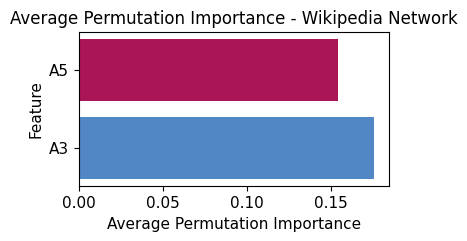

In [ ]:
### PLOT ###

# Get the colors
colors_importance = ["#5287C6", "#AA1555"]

# Make the figure
plt.figure(figsize = (4, 2))
plt.barh(importances_wiki["Feature"],
         importances_wiki["Average Permutation importance"],
         color = colors_importance)
plt.xlabel("Average Permutation Importance", fontsize = 11)
plt.ylabel("Feature", fontsize = 11)
plt.title("Average Permutation Importance - Wikipedia Network", fontsize = 12)
plt.yticks(fontsize = 11)
plt.xticks(fontsize = 11)

# Save as pdf
plt.savefig("importance_wiki.png",
            dpi=300,
            bbox_inches="tight")

# Show the plot
plt.show()

**Precision / Recall Curve**

<Figure size 800x600 with 0 Axes>

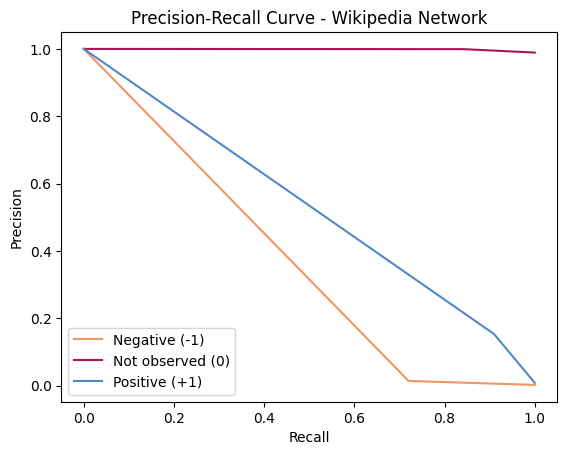

In [ ]:
# Convert Y and Y_pred to binary, because it is multilevel
Y_wiki_bin = label_binarize(Y_wiki_full, classes = np.unique(Y_wiki_full))
Y_pred_wiki_bin = label_binarize(Y_pred_wiki, classes = np.unique(Y_wiki_full))

# Define label names
label_names = ["Negative (-1)", "Not observed (0)", "Positive (+1)"]
colors_prerecall = ["#F3965E", "#AA1555", "#5287C6"]

# Plot the precision recall curve for each sign
plt.figure(figsize = (8, 6))
fig, ax = plt.subplots()
for i in range(len(label_names)):
  precision, recall, _ = precision_recall_curve(Y_wiki_bin[:, i],
                                                Y_pred_wiki_bin[:, i])
  ax.plot(recall, precision, label = label_names[i], color = colors_prerecall[i])

# Title, axis etc
ax.set_xlabel("Recall", fontsize = 10)
ax.set_ylabel("Precision", fontsize = 10)
ax.set_title("Precision-Recall Curve - Wikipedia Network", fontsize = 12)
ax.legend(fontsize = 10)
ax.tick_params(axis = "both", labelsize = 10)

# Save as png
plt.savefig("precision_recall_wiki.png",
            dpi=500,
            bbox_inches="tight")

plt.show()


**AUC Curve**

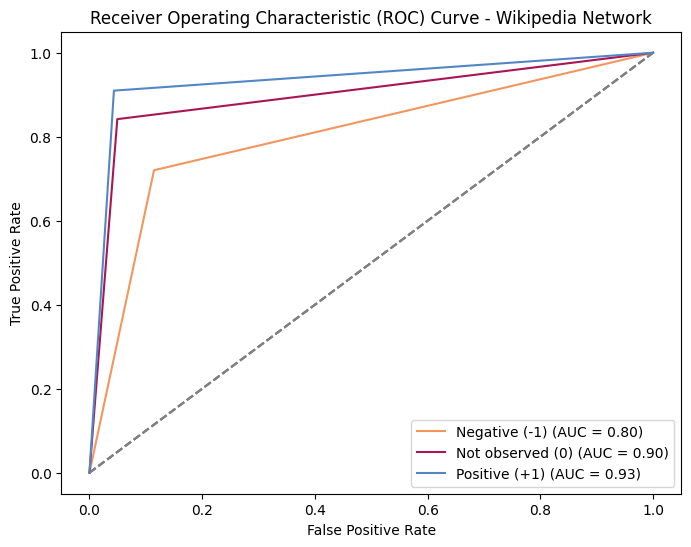

In [ ]:
# Compute the AUC scores
auc_scores = []

for i in range(3):
  auc = roc_auc_score(Y_wiki_bin[:, i], Y_pred_wiki_bin[:, i])
  auc_scores.append(auc)

# Plot the AUC curve for each sign
plt.figure(figsize = (8, 6))

for i in range(3):
  fpr, tpr, thresholds = roc_curve(Y_wiki_bin[:, i], Y_pred_wiki_bin[:, i])
  plt.plot([0, 1], [0, 1], color = "gray", linestyle = "--")
  plt.plot(fpr, tpr, color = colors_prerecall[i], label = label_names[i] + " (AUC = %0.2f)" % auc_scores[i])


# Set title and axis labels
plt.xlabel("False Positive Rate", fontsize = 10)
plt.ylabel("True Positive Rate", fontsize = 10)
plt.title("Receiver Operating Characteristic (ROC) Curve - Wikipedia Network", fontsize = 12)
plt.legend(loc="lower right", fontsize = 10)
plt.yticks(fontsize = 10)
plt.xticks(fontsize = 10)

# Save as png
plt.savefig("auc_roc_wiki.png",
            dpi=500,
            bbox_inches="tight")

plt.show()


**Precision, Recall, F1 plot**

In [ ]:
# Model Performance measurements
precision = precision_score(Y_wiki_full, Y_pred_wiki, average = None, labels=[-1, 0, 1])
recall = recall_score(Y_wiki_full, Y_pred_wiki, average = None, labels=[-1, 0, 1])
f1 = f1_score(Y_wiki_full, Y_pred_wiki, average = None, labels=[-1, 0, 1])

scores = np.array([precision, recall, f1])
metrics = ["Precision", "Recall", "F1 score"]
categories = ["Negative (-1)", "Not Observed (0)", "Positive (+1)"]


<Figure size 500x300 with 0 Axes>

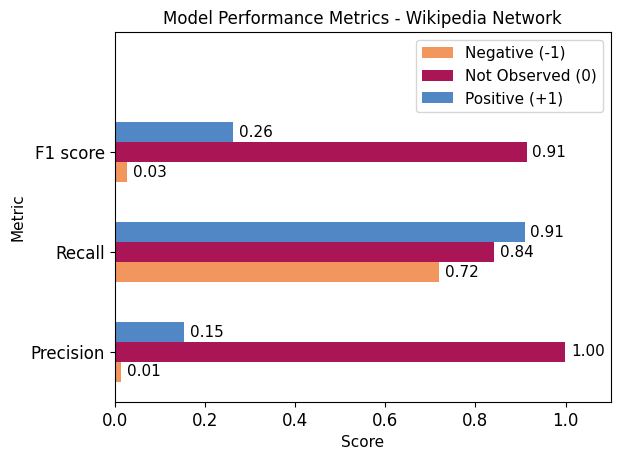

In [ ]:
# Make the plot
plt.figure(figsize=(5, 3))
fig, ax = plt.subplots()

bar_width = 0.2
text_shift = 0.05
bar_positions = np.arange(3)

for i in range(3):

    # Calculate the offset for each category
    offset = (i - 3/2 + 0.5) * bar_width

    # Plot the bars for each metric with the corresponding category data
    ax.barh(bar_positions + offset, scores[:, i], height=bar_width,
            label=categories[i], color=colors_prerecall[i])

    # Plot the text
    # Add text in each bar
    for j, score in enumerate(scores[:, i]):
        ax.text(score + text_shift, bar_positions[j] + offset, f"{score:.2f}", ha = "center", va = "center", fontsize = 11)


# Set axis labels and title
ax.set_xlabel("Score", fontsize = 11)
ax.set_ylabel("Metric", fontsize = 11)
ax.set_title("Model Performance Metrics - Wikipedia Network", fontsize = 12)

# Set the y-tick positions and labels to the metric names
ax.set_yticks(bar_positions)
ax.set_yticklabels(metrics)
ax.tick_params(axis = "both", labelsize = 12)
ax.set_ylim(-0.5,3.2)
ax.set_xlim(0, 1.1)

# Add a legend
ax.legend(fontsize = 11,
          loc = "upper right")

# Save as png
plt.savefig("model_performance_wiki.png",
            dpi=500,
            bbox_inches="tight")

plt.show()

**Confusion Matrix plot (heatmap)**

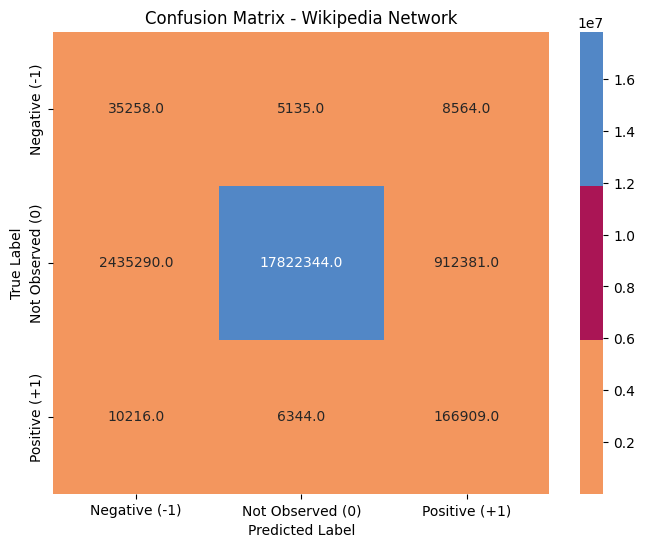

In [ ]:
cm = confusion_matrix(Y_wiki_full, Y_pred_wiki)

# Create confusion matrix heatmap
plt.figure(figsize = (8,6))
ax = plt.gca()

sns.heatmap(cm, annot = True, cmap = colors_prerecall, fmt = ".1f", ax = ax)

# Set the axis labels and title
ax.set_xlabel("Predicted Label", fontsize = 10)
ax.set_ylabel("True Label", fontsize = 10)
ax.set_title("Confusion Matrix - Wikipedia Network", fontsize = 12)
ax.set_xticklabels(categories, fontsize = 10)
ax.set_yticklabels(categories, fontsize = 10)


# Save as png
plt.savefig("cm_wiki.png",
            dpi=500,
            bbox_inches="tight")

# Show the plot
plt.show()

### 6.2 School Model

#### 6.2.1 Predictorset

The following features will be included:

- A2
- A3
- A4
- A5
- OUTDEGREE_SOURCE
- NEG_INDEGREE_SOURCE
- EIGENVECTOR_SOURCE
- CLUSTERING_SOURCE
- NEG_INDEGREE_TARGET
- CLUSTERING_TARGET
- SALTON
- HPI
- SOCIALSTATUS_TARGET

**Baseline model**

In [ ]:
# Extract baseline predictorset
x_school_full = baseline(g_school)

# Add the other predictor (CLASSID and SCHOOLID)
x_school_full = x_school_full.merge(school_df_order[["youthid", "classid", "schoolid"]],
                          left_on=["SOURCE"],
                          right_on=["youthid"],
                          how="left")
x_school_full.rename(columns={"classid": "CLASSID_SOURCE", "schoolid": "SCHOOLID_SOURCE"}, inplace=True)
x_school_full.drop(columns=["youthid"], inplace=True)
x_school_full = x_school_full.merge(school_df_order[["youthid", "classid", "schoolid"]],
                          left_on=["TARGET"],
                          right_on=["youthid"],
                          how="left")
x_school_full.rename(columns={"classid": "CLASSID_TARGET", "schoolid": "SCHOOLID_TARGET"}, inplace=True)
x_school_full.drop(columns=["youthid"], inplace=True)

**Add higher order cycles**

In [ ]:
# Extract higher order cycles
x_school_full, A_school_full, A2_school_full, A3_school_full, A4_school_full, A5_school_full = higher_order_cycles(g_school, x_school_full)

**Add node level and network level predictors**

In [ ]:
# Extract the outdegree
outdegree = pd.Series(dict(g_school.out_degree()), name="OUTDEGREE")

# Extract the eigenvector
eigenvector = pd.Series(nx.eigenvector_centrality(g_school,
                                                    max_iter=1000),
                                                  name="EIGENVECTOR")

# Extract negative indegree
positive_indegree, negative_indegree = posnegindegree(g_school)
negative_indegree = pd.Series(negative_indegree,
                                name = "NEG_INDEGREE")
positive_indegree = pd.Series(positive_indegree,
                              name = "POS_INDEGREE")

# Extract clustering coefficient
clustering = pd.Series(nx.algorithms.cluster.clustering(g_school))


# Transform Series into DataFrame
df = pd.DataFrame({"EIGENVECTOR" : eigenvector,
                   "NEG_INDEGREE" : negative_indegree,
                   "CLUSTERING" : clustering,
                   "POS_INDEGREE" : positive_indegree,
                   "OUTDEGREE" : outdegree})
df.reset_index(inplace = True)
df.rename(columns = {"index" : "NODE"},
          inplace = True)

# Merge DataFrame with predictorset x_school_full
x_school_full = x_school_full.merge(df,
                                left_on = "SOURCE",
                                right_on = "NODE",
                                how = "left")
x_school_full.rename(columns = {"EIGENVECTOR" : "EIGENVECTOR_SOURCE",
                                "NEG_INDEGREE" : "NEG_INDEGREE_SOURCE",
                                "CLUSTERING" : "CLUSTERING_SOURCE",
                                "POS_INDEGREE" : "POS_INDEGREE_SOURCE",
                                "OUTDEGREE" : "OUTDEGREE_SOURCE"},
                     inplace = True)

# Merge now for target
x_school_full = x_school_full.merge(df,
                                left_on = "TARGET",
                                right_on = "NODE",
                                how = "left")
x_school_full.rename(columns = {"NEG_INDEGREE" : "NEG_INDEGREE_TARGET",
                                "POS_INDEGREE" : "POS_INDEGREE_TARGET",
                              "EIGENVECTOR" : "EIGENVECTOR_TARGET",
                              "CLUSTERING" : "CLUSTERING_TARGET"},
                   inplace = True)


**Add link prediction methods**

In [ ]:
# Extract the salton index
salton = salton_index(g_school)

# Extract HPI index
hpi = hub_promoted_index(g_school)

# Transform into DataFrame
df = pd.DataFrame({"SOURCE" : list(zip(*salton))[0],
                   "TARGET" : list(zip(*salton))[1],
                   "SALTON" : list(zip(*salton))[2],
                   "HPI" : list(zip(*hpi))[2]})

# Merge with predictorset x_wiki_full
x_school_full = pd.merge(x_school_full,
                       df,
                       on = ["SOURCE", "TARGET"])

**Add social status theory**

In [ ]:
# Add social status
socialstatus_source_wiki, socialstatus_target_wiki = social_status(x_school_full)
x_school_full["SOCIALSTATUS_TARGET"] = socialstatus_target_wiki

**Delete unnecessary columns and links with different classID and save to CSV**

In [ ]:
# Remove unnecessary columns
x_school_full.drop(columns = ["NODE_x", "NODE_y", "POS_INDEGREE_SOURCE", "OUTDEGREE", "POS_INDEGREE_TARGET", "EIGENVECTOR_TARGET"],
                 inplace = True)

In [ ]:
# Delete the edges with not the same classID
x_school_full = delete_same_class(x_school_full)

In [ ]:
x_school_full.columns

Index(['SOURCE', 'TARGET', 'CLASSID_SOURCE', 'SCHOOLID_SOURCE',
       'CLASSID_TARGET', 'SCHOOLID_TARGET', 'VOTE', 'A2', 'A3', 'A4', 'A5',
       'EIGENVECTOR_SOURCE', 'NEG_INDEGREE_SOURCE', 'CLUSTERING_SOURCE',
       'OUTDEGREE_SOURCE', 'NEG_INDEGREE_TARGET', 'CLUSTERING_TARGET',
       'SALTON', 'HPI', 'SOCIALSTATUS_TARGET'],
      dtype='object')

In [ ]:
# Save to csv
path = "/content/drive/My Drive/x_school_full.csv"
x_school_full.to_csv(path,
                     index = False)

#### 6.2.2 Data Analysis

In [ ]:
def cv_comparison_school(models, X, y, cv):

    """
    Do a K-fold cross validation between multiple models.

    Args:
      models = different models
      X = predictor set
      y = target variable
      cv = CrossValidation method

    Return:
      cv_metrics = DataFrame with performance measurements
      metrics = array with raw results
    """
    # Initialize a DataFrame for the averages and a list for all measures
    cv_metrics = pd.DataFrame()
    metrics = []

    # Define the scoring metrics
    scoring = {
        "precision_class_-1": make_scorer(precision_score, average=None, labels=[-1]),
        "precision_class_0": make_scorer(precision_score, average=None, labels=[0]),
        "precision_class_1": make_scorer(precision_score, average=None, labels=[1]),
        "recall_class_-1": make_scorer(recall_score, average=None, labels=[-1]),
        "recall_class_0": make_scorer(recall_score, average=None, labels=[0]),
        "recall_class_1": make_scorer(recall_score, average=None, labels=[1]),
        "f1_macro": make_scorer(precision_score, average="macro"),
        "f1": make_scorer(f1_score, average="weighted"),
        "accuracy": make_scorer(accuracy_score)
    }

    #Extract classID
    class_id = X["CLASSID_SOURCE"]

    # Perform cross-validation
    scores = cross_validate(models, X, y, scoring=scoring, cv=cv.split(X, class_id), n_jobs = -1, return_estimator = True)

    # Obtain prediction values
    Y_pred = cross_val_predict(models, X, y, cv=cv.split(X, class_id), n_jobs = -1)

    # Extract the metric scores
    precision_class_minus_1 = np.round(scores["test_precision_class_-1"].mean(), 4)
    precision_class_0 = np.round(scores["test_precision_class_0"].mean(), 4)
    precision_class_1 = np.round(scores["test_precision_class_1"].mean(), 4)
    recall_class_minus_1 = np.round(scores["test_recall_class_-1"].mean(), 4)
    recall_class_0 = np.round(scores["test_recall_class_0"].mean(), 4)
    recall_class_1 = np.round(scores["test_recall_class_1"].mean(), 4)
    f1_macro = np.round(scores["test_f1_macro"].mean(), 4)
    f1 = np.round(scores["test_f1"].mean(), 4)
    accuracy = np.round(scores["test_accuracy"].mean(), 4)

    # Add the metric scores to the DataFrame
    cv_metrics[str(models)] = [
        precision_class_minus_1,
        precision_class_0,
        precision_class_1,
        recall_class_minus_1,
        recall_class_0,
        recall_class_1,
        f1_macro,
        f1,
        accuracy]

    # Add the metric scores to the list
    metrics.append(scores)

    cv_metrics.index = ["Precision_class_-1", "Precision_class_0", "Precision_class_1",
                    "Recall_class_-1", "Recall_class_0", "Recall_class_1",
                    "F1 Macro", "F1", "Accuracy"]

    return cv_metrics, metrics, Y_pred, scores


In [ ]:
### FEATURE COMPONENTS ###

# Extract feature components
Y_school_full = x_school_full.pop("VOTE")
X_school_full = x_school_full.drop(columns = ["SOURCE", "TARGET",  "CLASSID_TARGET", "SCHOOLID_SOURCE", "SCHOOLID_TARGET"]) #drop irrelevant columns and columns with missing variables

# Set number of folds
k = 5

### MAKE WEIGHTS ###

# Convert class labels to integers
class_labels = np.unique(Y_school_full)
label_mapping = {label: i for i, label in enumerate(class_labels)}
Y_school_int = np.array([label_mapping[label] for label in Y_school_full])

# Compute class counts
class_counts = np.bincount((Y_school_int))  # Use absolute values for computing class counts

# Compute total number of samples
total_samples = np.sum(class_counts)

# Define the weights for the model for each class
weights_school = {label: total_samples / count for label, count in zip(class_labels, class_counts)}

### STRATIFIED CROSS VALIDATION ###

# Make the stratified kfold component
skf = StratifiedKFold(n_splits = k,
                      shuffle = True,
                      random_state = 42)

### MODEL SET UP ####

lgbm_school = lgb.LGBMClassifier(n_estimators = 200,
                            learning_rate = 0.01,
                            max_depth = 7,
                            num_leaves = 15,
                            class_weight = weights_school)


In [ ]:
### DATA ANALYSIS ###
cv_metrics_school, metrics_school, Y_pred_school, scores_school = cv_comparison_school(lgbm_school, X_school_full, Y_school_full, skf)

In [ ]:
# Save to pandas dataframe
Y_pred_school = pd.DataFrame(Y_pred_school)

# Save to csv
path = "/content/drive/My Drive/y_pred_school.csv"
Y_pred_school.to_csv(path,
                   index = False)


In [ ]:
cv_metrics_school

LGBMClassifier(class_weight={-1.0: 4.657512458912098, 0.0: 1.7804304649183251,\n                             1.0: 4.471648172656011},\n               learning_rate=0.01, max_depth=7, n_estimators=200,\n               num_leaves=15)
Precision_class_-1                                             0.6736                                                                                                                                                                                      
Precision_class_0                                              0.8829                                                                                                                                                                                      
Precision_class_1                                              0.7206                                                                                                                                                                                      
Recall_class_-1                                                0.8391                                                                                                                                                                                      
Recall_class_0                                                 0.7160                                                                                                                                                                                      
Recall_class_1                                                 0.8926                                                                                                                                                                                      
F1 Macro                                                       0.7590                                                                                                                                                                                      
F1                                                             0.7829                                                                                                                                                                                      
Accuracy                                                       0.7819

In [ ]:
metrics_school

[{'fit_time': array([4.11828446, 4.0688169 , 5.51586413, 4.05619383, 5.45218062]),
  'score_time': array([0.46606112, 0.46197939, 0.46035075, 0.48050499, 0.47402644]),
  'estimator': [LGBMClassifier(class_weight={-1.0: 4.657512458912098, 0.0: 1.7804304649183251,
                                1.0: 4.471648172656011},
                  learning_rate=0.01, max_depth=7, n_estimators=200,
                  num_leaves=15),
   LGBMClassifier(class_weight={-1.0: 4.657512458912098, 0.0: 1.7804304649183251,
                                1.0: 4.471648172656011},
                  learning_rate=0.01, max_depth=7, n_estimators=200,
                  num_leaves=15),
   LGBMClassifier(class_weight={-1.0: 4.657512458912098, 0.0: 1.7804304649183251,
                                1.0: 4.471648172656011},
                  learning_rate=0.01, max_depth=7, n_estimators=200,
                  num_leaves=15),
   LGBMClassifier(class_weight={-1.0: 4.657512458912098, 0.0: 1.7804304649183251,
           

#### 6.1.3 Plots / Visualizations

**Feature Importance**

In [ ]:
# Calculate permutation importance for each estimator
importances = []
for estimator in scores_school["estimator"]:
  # Calculate permutation importance
  result = permutation_importance(estimator,
                                  X_school_full,
                                  Y_school_full,
                                  scoring = "f1_macro",
                                  n_repeats = 5,
                                  random_state = 42)
  importances.append(result.importances_mean)


In [ ]:
# Make the dataframe with importances per predictor
mean_importances_school = np.mean(importances, axis = 0)
importances_school = pd.DataFrame({"Feature" : X_school_full.columns,
                                 "Average Permutation importance" : np.mean(importances, axis = 0)})

# Save to csv
path = "/content/drive/My Drive/importances_school.csv"
importances_school.to_csv(path,
              index = False)

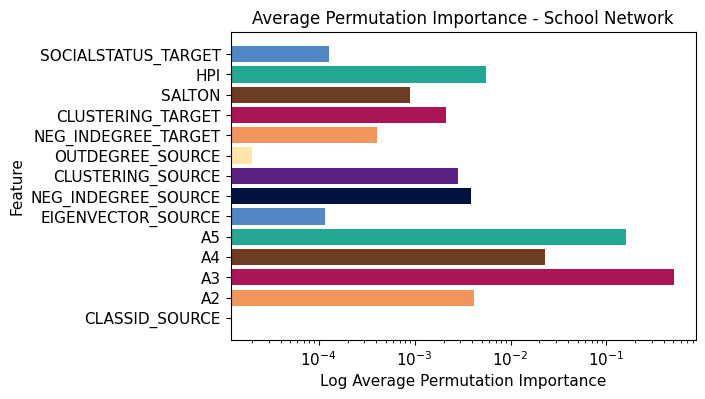

In [ ]:
### PLOT ###
# Get the colors
colors_importance = ["#FFE6AB", "#F3965E", "#AA1555", "#6E3B23", "#24A793", "#5287C6", "#001240", "#5B2182"]

# Make the figure
plt.figure(figsize = (6, 4))
plt.barh(importances_school["Feature"],
         importances_school["Average Permutation importance"],
         color = colors_importance)
plt.xscale("log")
plt.xlabel("Log Average Permutation Importance", fontsize = 11)
plt.ylabel("Feature", fontsize = 11)
plt.title("Average Permutation Importance - School Network", fontsize = 12)
plt.yticks(fontsize = 11)
plt.xticks(fontsize = 11)

# Save as pdf
plt.savefig("importance_school.png",
            dpi=300,
            bbox_inches="tight")

# Show the plot
plt.show()

**Precision / Recall Curve**

<Figure size 800x600 with 0 Axes>

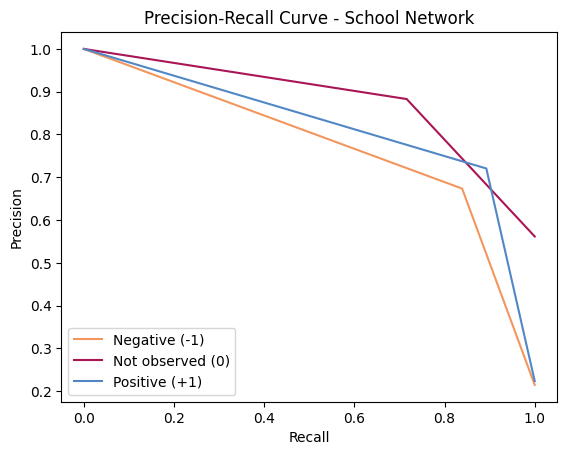

In [ ]:
# Convert Y and Y_pred to binary, because it is multilevel
Y_school_bin = label_binarize(Y_school_full.astype(int), classes = np.unique(Y_school_full.astype(int)))
Y_pred_school_bin = label_binarize(Y_pred_school.astype(int), classes = np.unique(Y_school_full.astype(int)))

# Define label names
label_names = ["Negative (-1)", "Not observed (0)", "Positive (+1)"]
colors_prerecall = ["#F3965E", "#AA1555", "#5287C6"]

# Plot the precision recall curve for each sign
plt.figure(figsize = (8, 6))
fig, ax = plt.subplots()

for i in range(len(label_names)):
  precision, recall, _ = precision_recall_curve(Y_school_bin[:, i],
                                                Y_pred_school_bin[:, i])
  ax.plot(recall, precision, label = label_names[i], color = colors_prerecall[i])

# Title, axis etc
ax.set_xlabel("Recall", fontsize = 10)
ax.set_ylabel("Precision", fontsize = 10)
ax.set_title("Precision-Recall Curve - School Network", fontsize = 12)
ax.legend(fontsize = 10)
ax.tick_params(axis = "both", labelsize = 10)

# Save as png
plt.savefig("precision_recall_school.png",
            dpi=500,
            bbox_inches="tight")

plt.show()


**AUC Curve**

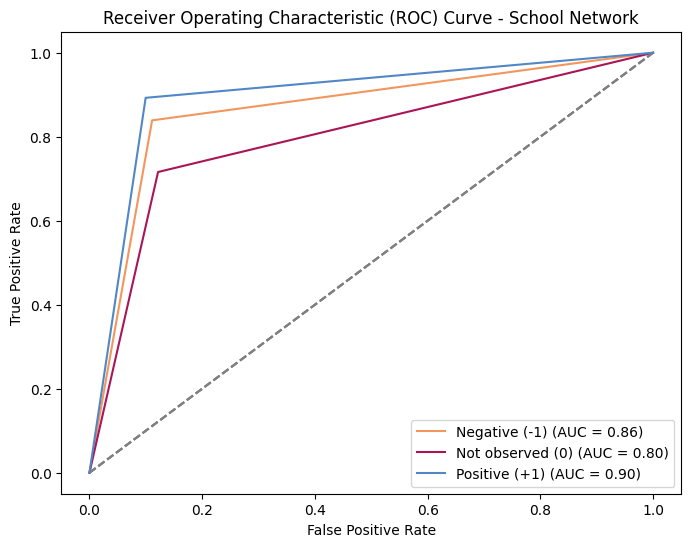

In [ ]:
# Compute the AUC scores
auc_scores = []

for i in range(3):
  auc = roc_auc_score(Y_school_bin[:, i], Y_pred_school_bin[:, i])
  auc_scores.append(auc)

# Plot the AUC curve for each sign
plt.figure(figsize = (8, 6))

for i in range(3):
  fpr, tpr, thresholds = roc_curve(Y_school_bin[:, i], Y_pred_school_bin[:, i])
  plt.plot([0, 1], [0, 1], color="gray", linestyle="--")
  plt.plot(fpr, tpr, color= colors_prerecall[i], label = label_names[i] + " (AUC = %0.2f)" % auc_scores[i])


# Set title and axis labels
plt.xlabel("False Positive Rate", fontsize = 10)
plt.ylabel("True Positive Rate", fontsize = 10)
plt.title("Receiver Operating Characteristic (ROC) Curve - School Network", fontsize = 12)
plt.legend(loc="lower right", fontsize = 10)
plt.yticks(fontsize = 10)
plt.xticks(fontsize = 10)

# Save as png
plt.savefig("auc_roc_school.png",
            dpi=500,
            bbox_inches="tight")

plt.show()


**Precision, Recall, F1 plot**

In [ ]:
# Model Performance measurements
precision = precision_score(Y_school_full, Y_pred_school, average = None)
recall = recall_score(Y_school_full, Y_pred_school, average = None)
f1 = f1_score(Y_school_full, Y_pred_school, average = None)

scores = np.array([precision, recall, f1])
metrics = ["Precision", "Recall", "F1 score"]
categories = ["Negative (-1)", "Not Observed (0)", "Positive (+1)"]



<Figure size 800x600 with 0 Axes>

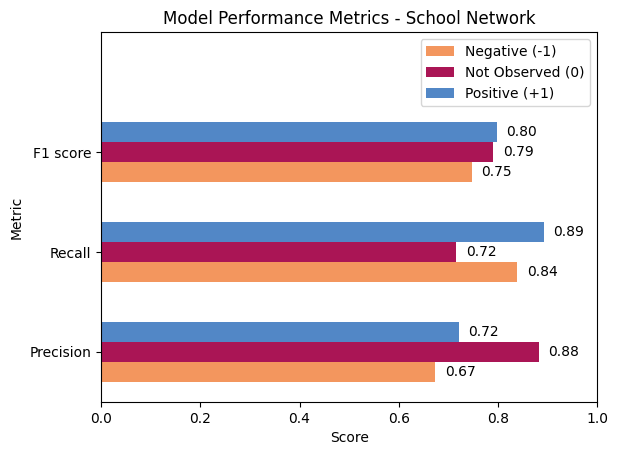

In [ ]:
# Make the plot
plt.figure(figsize=(8, 6))
fig, ax = plt.subplots()

bar_width = 0.2
text_shift = 0.05
bar_positions = np.arange(3)

for i in range(3):

    # Calculate the offset for each category
    offset = (i - 3/2 + 0.5) * bar_width

    # Plot the bars for each metric with the corresponding category data
    ax.barh(bar_positions + offset, scores[:, i], height=bar_width,
            label=categories[i], color=colors_prerecall[i])

    # Plot the text
     # Add text in each bar
    for j, score in enumerate(scores[:, i]):
        ax.text(score + text_shift, bar_positions[j] + offset, f"{score:.2f}", ha = "center", va = "center")

# Set axis labels and title
ax.set_xlabel("Score", fontsize = 10)
ax.set_ylabel("Metric", fontsize = 10)
ax.set_title("Model Performance Metrics - School Network", fontsize = 12)

# Set the y-tick positions and labels to the metric names
ax.set_yticks(bar_positions)
ax.set_yticklabels(metrics)
ax.tick_params(axis = "both", labelsize = 10)
ax.set_ylim(-0.5,3.2)
ax.set_xlim(0, 1)

# Add a legend
ax.legend(fontsize = 10, loc = "upper right")

# Save as png
plt.savefig("model_performance_school.png",
            dpi=500,
            bbox_inches="tight")

plt.show()

**Confusion Matrix plot (heatmap)**

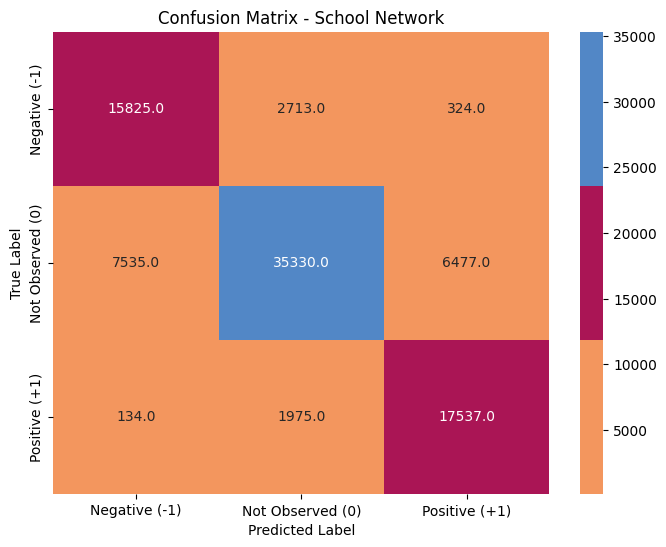

In [ ]:
cm = confusion_matrix(Y_school_full, Y_pred_school)

# Create confusion matrix heatmap
plt.figure(figsize = (8,6))
ax = plt.gca()

sns.heatmap(cm, annot=True, cmap=colors_prerecall, fmt=".1f", ax=ax)

# Set the axis labels and title
ax.set_xlabel("Predicted Label", fontsize = 10)
ax.set_ylabel("True Label", fontsize = 10)
ax.set_title("Confusion Matrix - School Network", fontsize = 12)
ax.set_xticklabels(categories, fontsize = 10)
ax.set_yticklabels(categories, fontsize = 10)


# Save as png
plt.savefig("cm_school.png",
            dpi=500,
            bbox_inches="tight")

# Show the plot
plt.show()